In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "072"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = False

expected_tokens = 1000  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.0)
wandb.config["lr"] = lr = 6e-6
wandb.config["betas"] = betas = (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 32
sync_dir = symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/56.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 03-12 00:19:58 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 00:19:59 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 00:19:59 api_server.py:841] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=N

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.51it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.43it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  2.08it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.78it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.74it/s]



INFO 03-12 00:20:39 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 00:20:40 worker.py:267] Memory profiling takes 1.16 seconds
INFO 03-12 00:20:40 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 00:20:40 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 00:20:41 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 00:20:41 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 00:21:23 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.12 seconds
INFO 03-12 00:21:24 api_server.py:756] Using supplied chat template:
INFO 03-12 00:21:24 api_server.py:756] None
INFO 03-12 00:21:24 launcher.py:21] Available routes are:
INFO 03-12 00:21:24 launcher.py:29] Route: 

INFO:     Started server process [6499]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 00:21:26 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:37070 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [02:14<00:00,  6.91s/it, completion_tokens=317, prompt_tokens=1391, reward=0.208, acc=0.208, early_stop=0.000625, token_logprobs=512381]


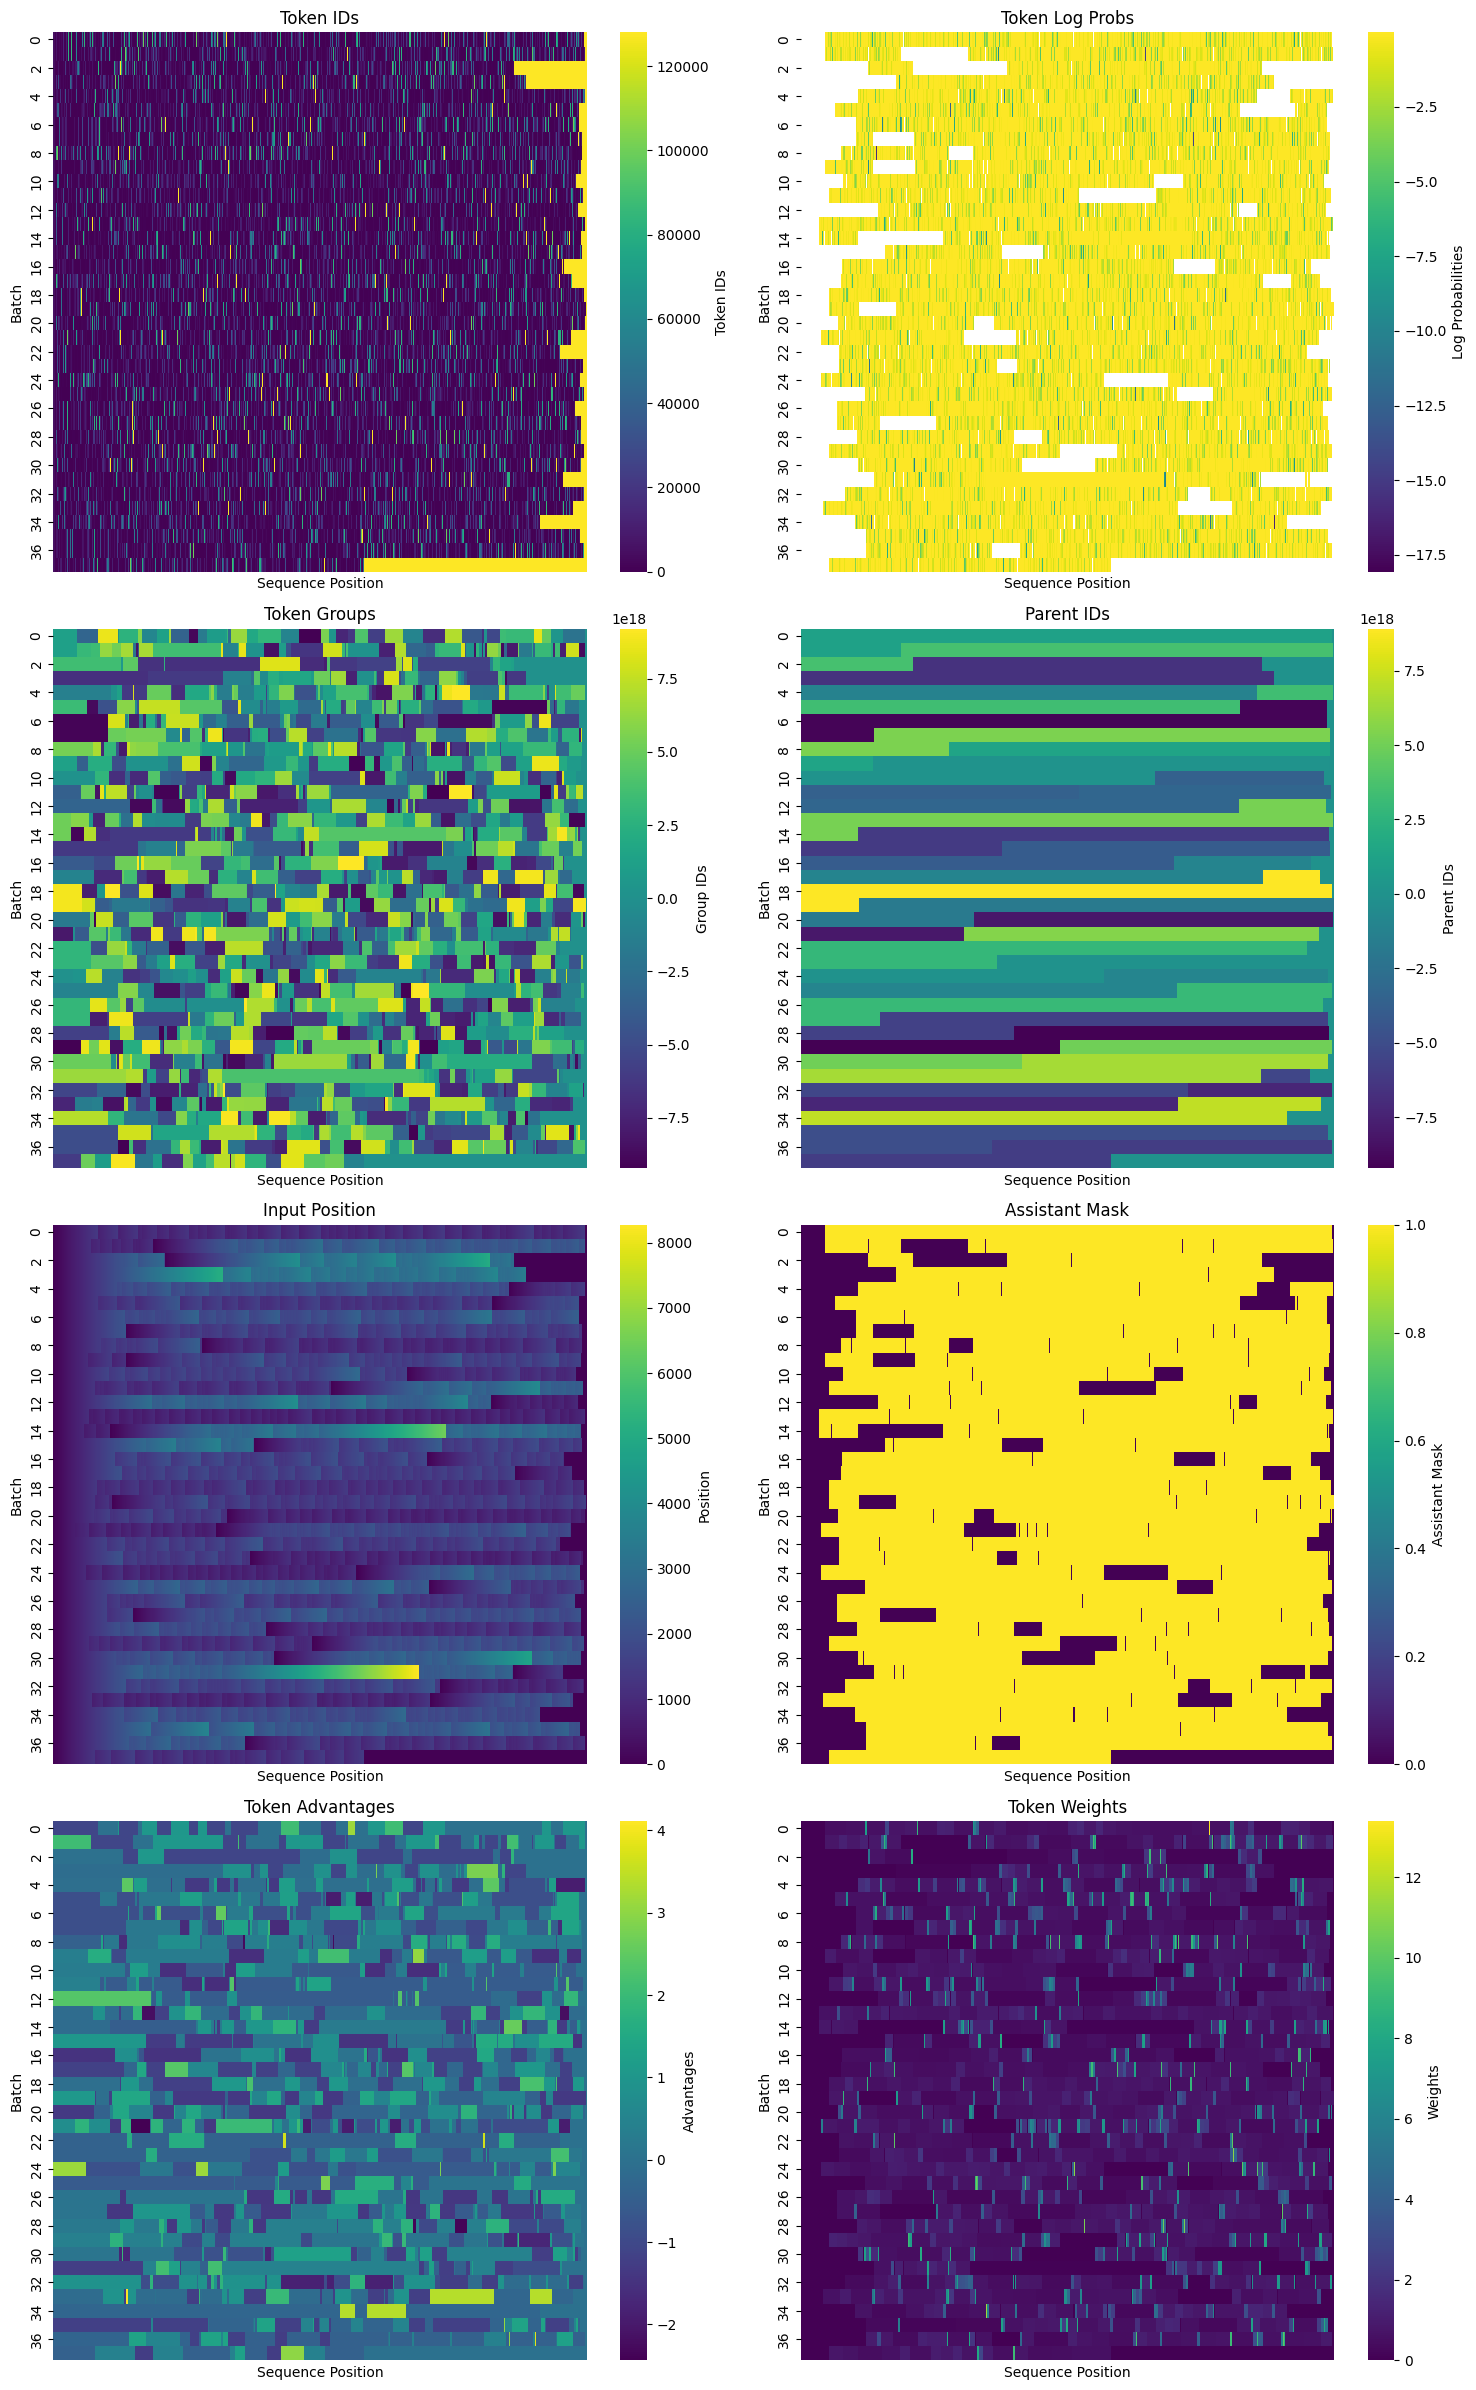

Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/15a75279e8911d4c1f515986546f6fcb5ad0717c
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/65efd9e0e3baa04473b66aa4ad473e9302cf7fc6
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - model-00003-of-00004.safetensors
  - model-00001-of-00004.safetensors
  - model-00004-of-00004.safetensors
  - model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 38
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation

Writing logs to models/072/logs/log_1741739046.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 16.96 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|19|Loss: -0.0000: 100%|██████████| 19/19 [05:11<00:00, 15.59s/it, loss=-8.58e-6, policy=-8.58e-6, entropy=0.427, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0001 --port=8000 --api-key=default
INFO 03-12 00:30:09 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 00:30:10 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 00:30:10 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.48it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.41it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.39it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.93it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.70it/s]



INFO 03-12 00:30:23 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 00:30:24 worker.py:267] Memory profiling takes 1.19 seconds
INFO 03-12 00:30:24 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 00:30:24 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 00:30:24 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 00:30:24 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 00:31:06 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.65 seconds
INFO 03-12 00:31:07 api_server.py:756] Using supplied chat template:
INFO 03-12 00:31:07 api_server.py:756] None
INFO 03-12 00:31:07 launcher.py:21] Available routes are:
INFO 03-12 00:31:07 launcher.py:29] Route: 

INFO:     Started server process [8380]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 00:31:09 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:57004 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [05:33<00:00,  2.07it/s, completion_tokens=491, prompt_tokens=1380, reward=0.266, acc=0.266, early_stop=0.0281, token_logprobs=965045]


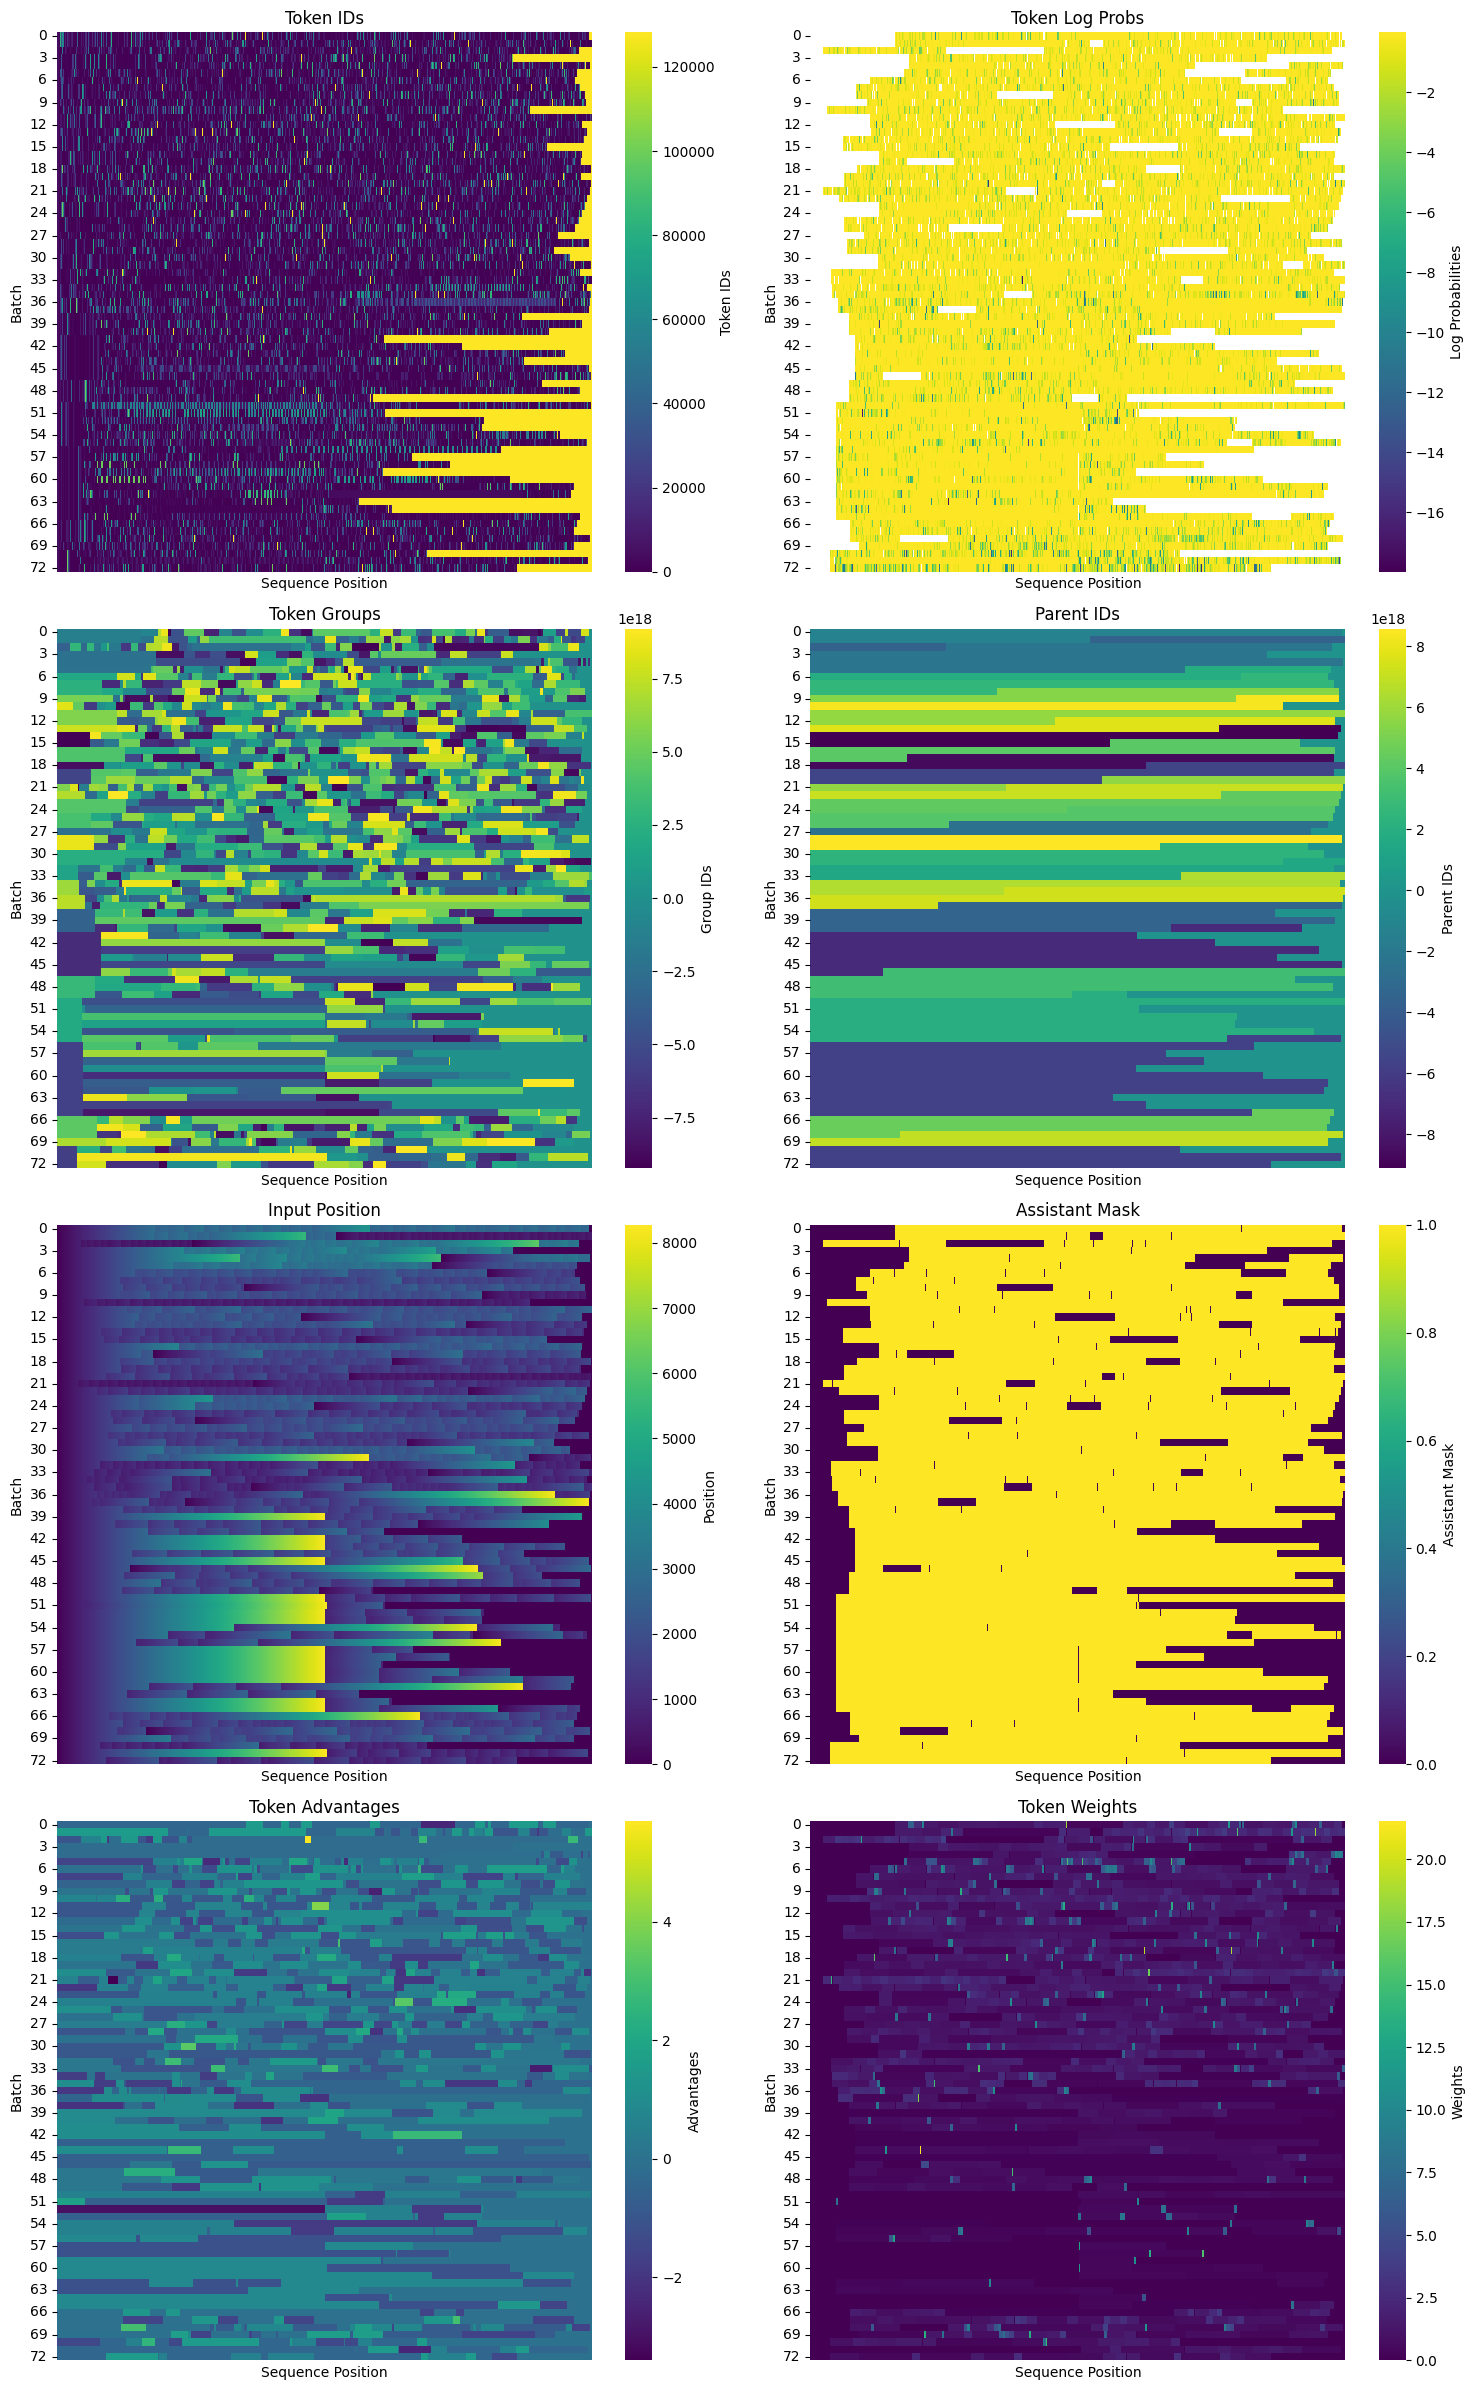

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0001
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 73
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741739829.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 16.90 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|36|Loss: -0.0278: 100%|██████████| 36/36 [09:29<00:00, 15.55s/it, loss=-0.0278, policy=-0.0278, entropy=0.41, kl_div=nan]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0002 --port=8000 --api-key=default
INFO 03-12 00:47:31 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 00:47:32 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 00:47:32 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.41it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.33it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.32it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.82it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.61it/s]



INFO 03-12 00:47:46 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 00:47:47 worker.py:267] Memory profiling takes 1.23 seconds
INFO 03-12 00:47:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 00:47:47 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 00:47:47 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 00:47:47 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 00:48:30 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.98 seconds
INFO 03-12 00:48:30 api_server.py:756] Using supplied chat template:
INFO 03-12 00:48:30 api_server.py:756] None
INFO 03-12 00:48:30 launcher.py:21] Available routes are:
INFO 03-12 00:48:30 launcher.py:29] Route: 

INFO:     Started server process [12070]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 00:48:32 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:43870 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [01:54<00:00,  3.91it/s, completion_tokens=71, prompt_tokens=1097, reward=0.327, acc=0.327, early_stop=0.00187, token_logprobs=192562]


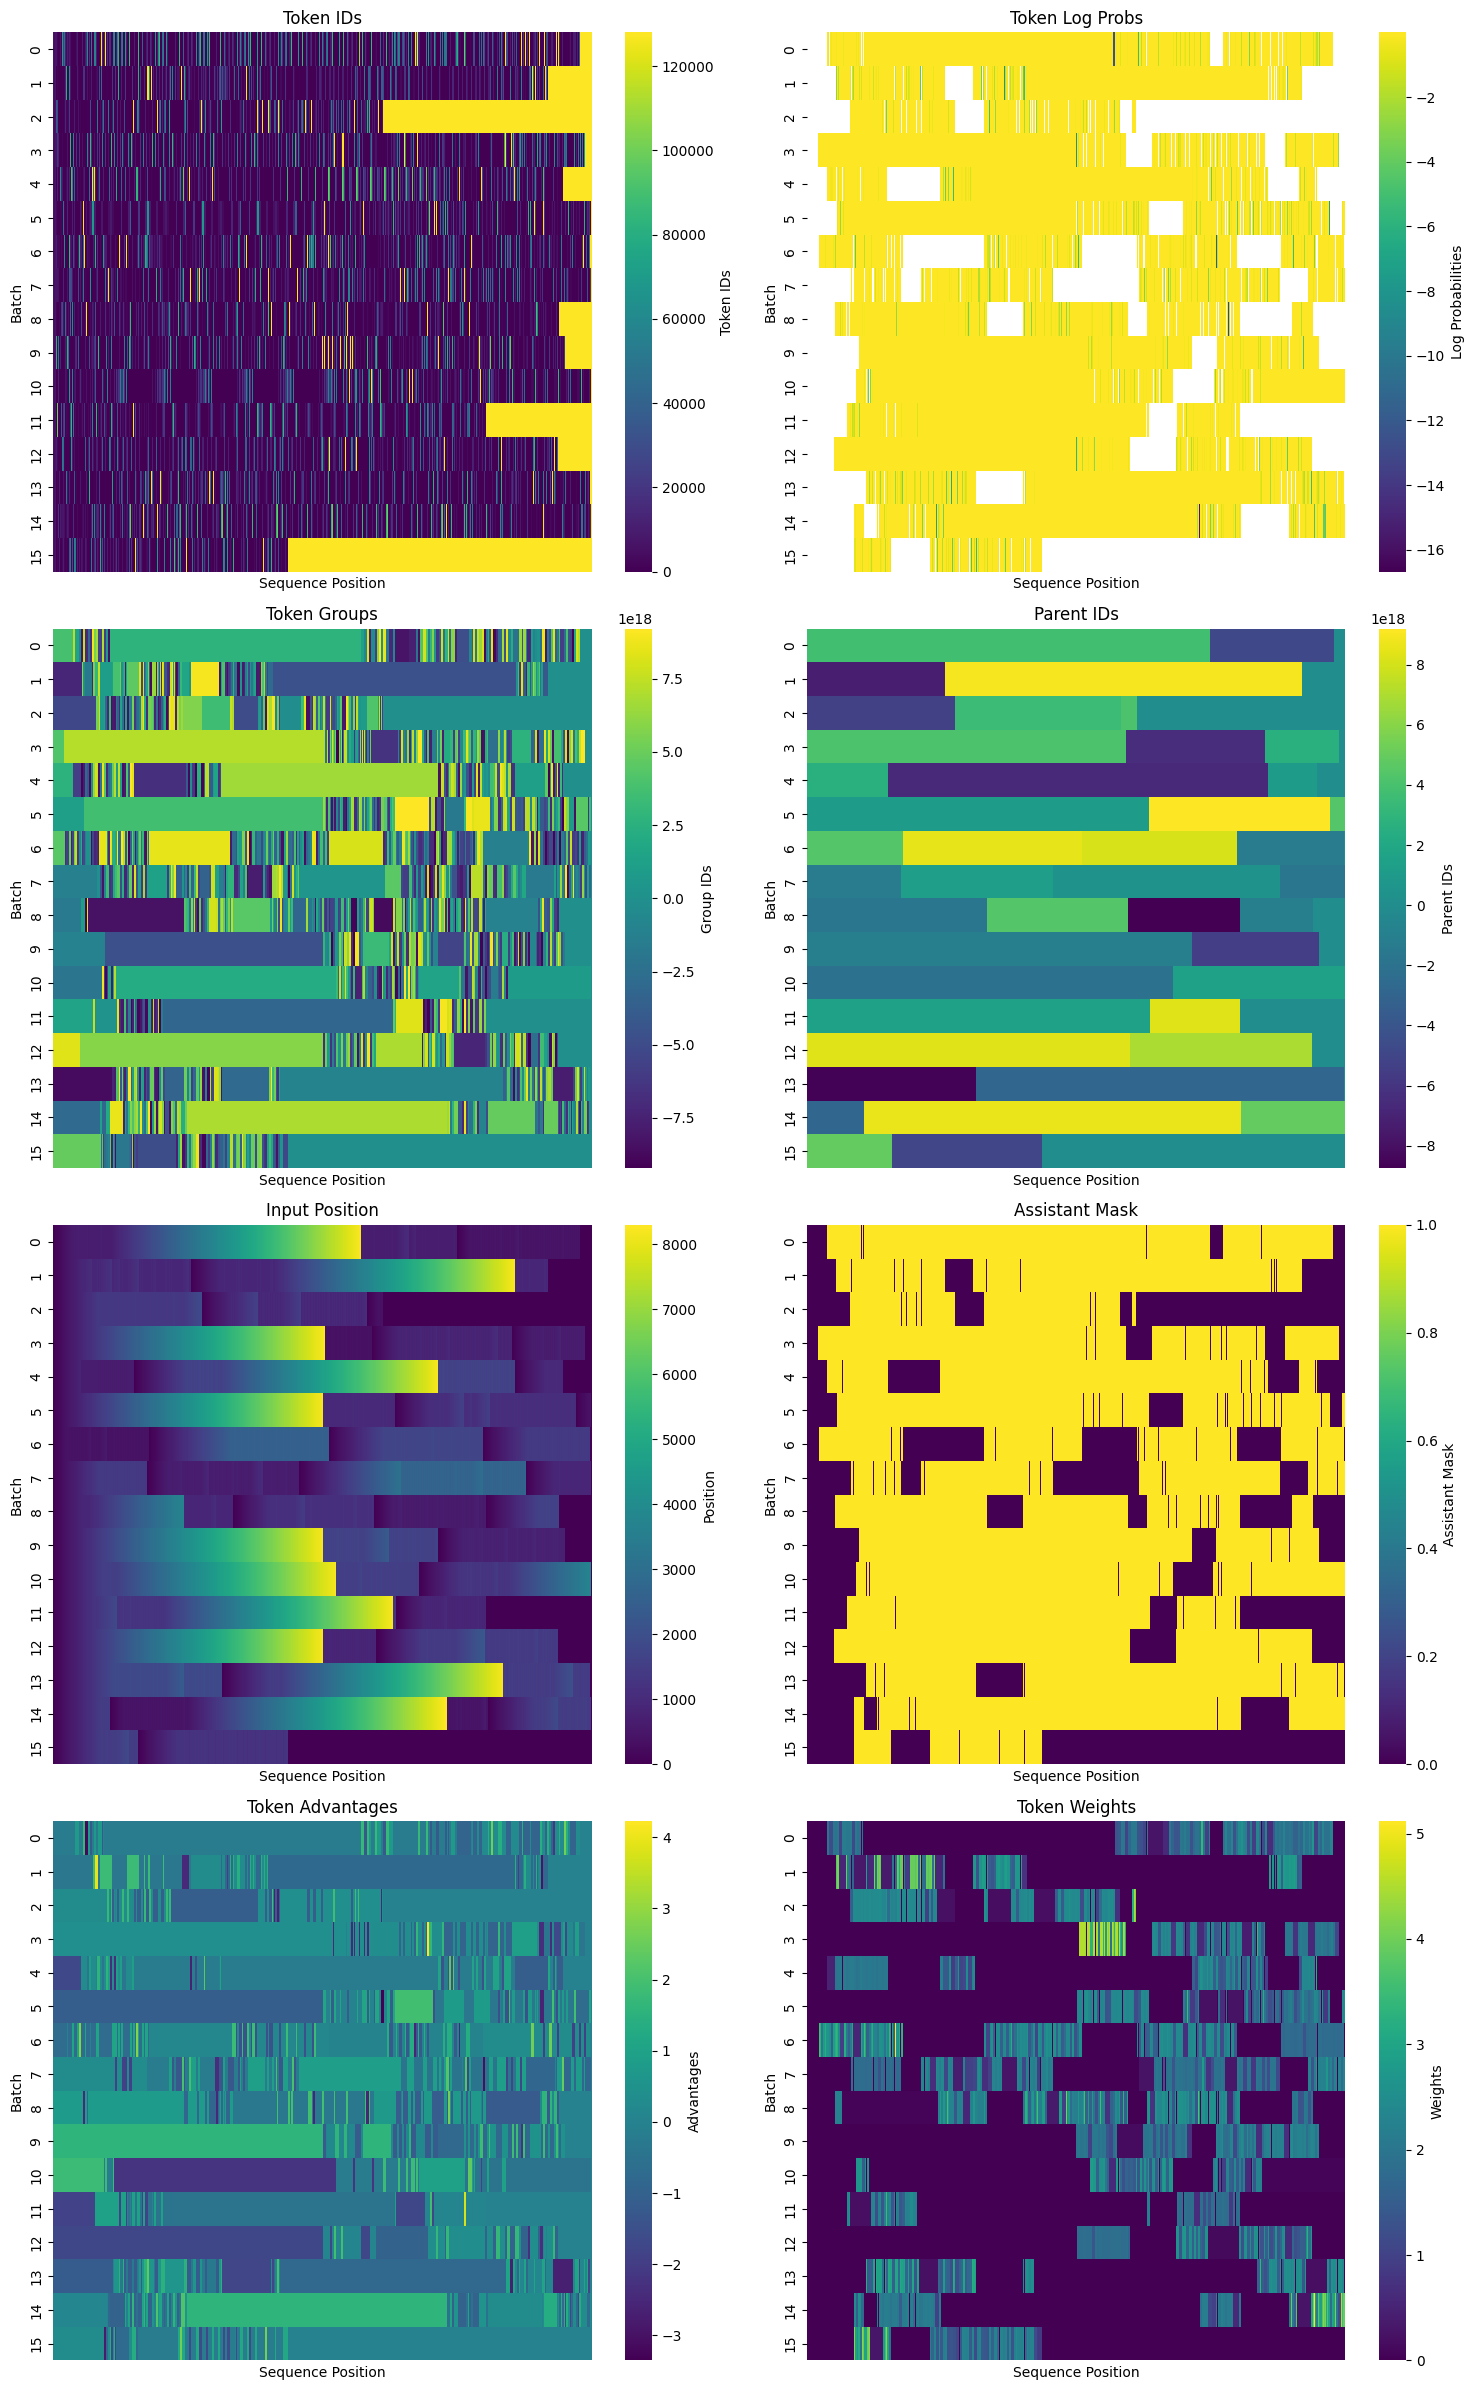

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0002
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 16
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741740647.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 17.14 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|8|Loss: 0.0326: 100%|██████████| 8/8 [02:13<00:00, 15.81s/it, loss=0.0326, policy=0.0326, entropy=0.109, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:to

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0003 --port=8000 --api-key=default
INFO 03-12 00:53:54 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 00:53:55 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 00:53:55 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.41it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.33it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.32it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.81it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.61it/s]



INFO 03-12 00:54:08 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 00:54:10 worker.py:267] Memory profiling takes 1.21 seconds
INFO 03-12 00:54:10 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 00:54:10 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 00:54:10 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 00:54:10 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 00:54:53 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.98 seconds
INFO 03-12 00:54:54 api_server.py:756] Using supplied chat template:
INFO 03-12 00:54:54 api_server.py:756] None
INFO 03-12 00:54:54 launcher.py:21] Available routes are:
INFO 03-12 00:54:54 launcher.py:29] Route: 

INFO:     Started server process [15564]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 00:54:56 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:53788 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [01:42<00:00,  4.87it/s, completion_tokens=69, prompt_tokens=1239, reward=0.384, acc=0.384, early_stop=0.000625, token_logprobs=118558]
Cleared iteration directory ./models/072/0001 except chat-completion-logs


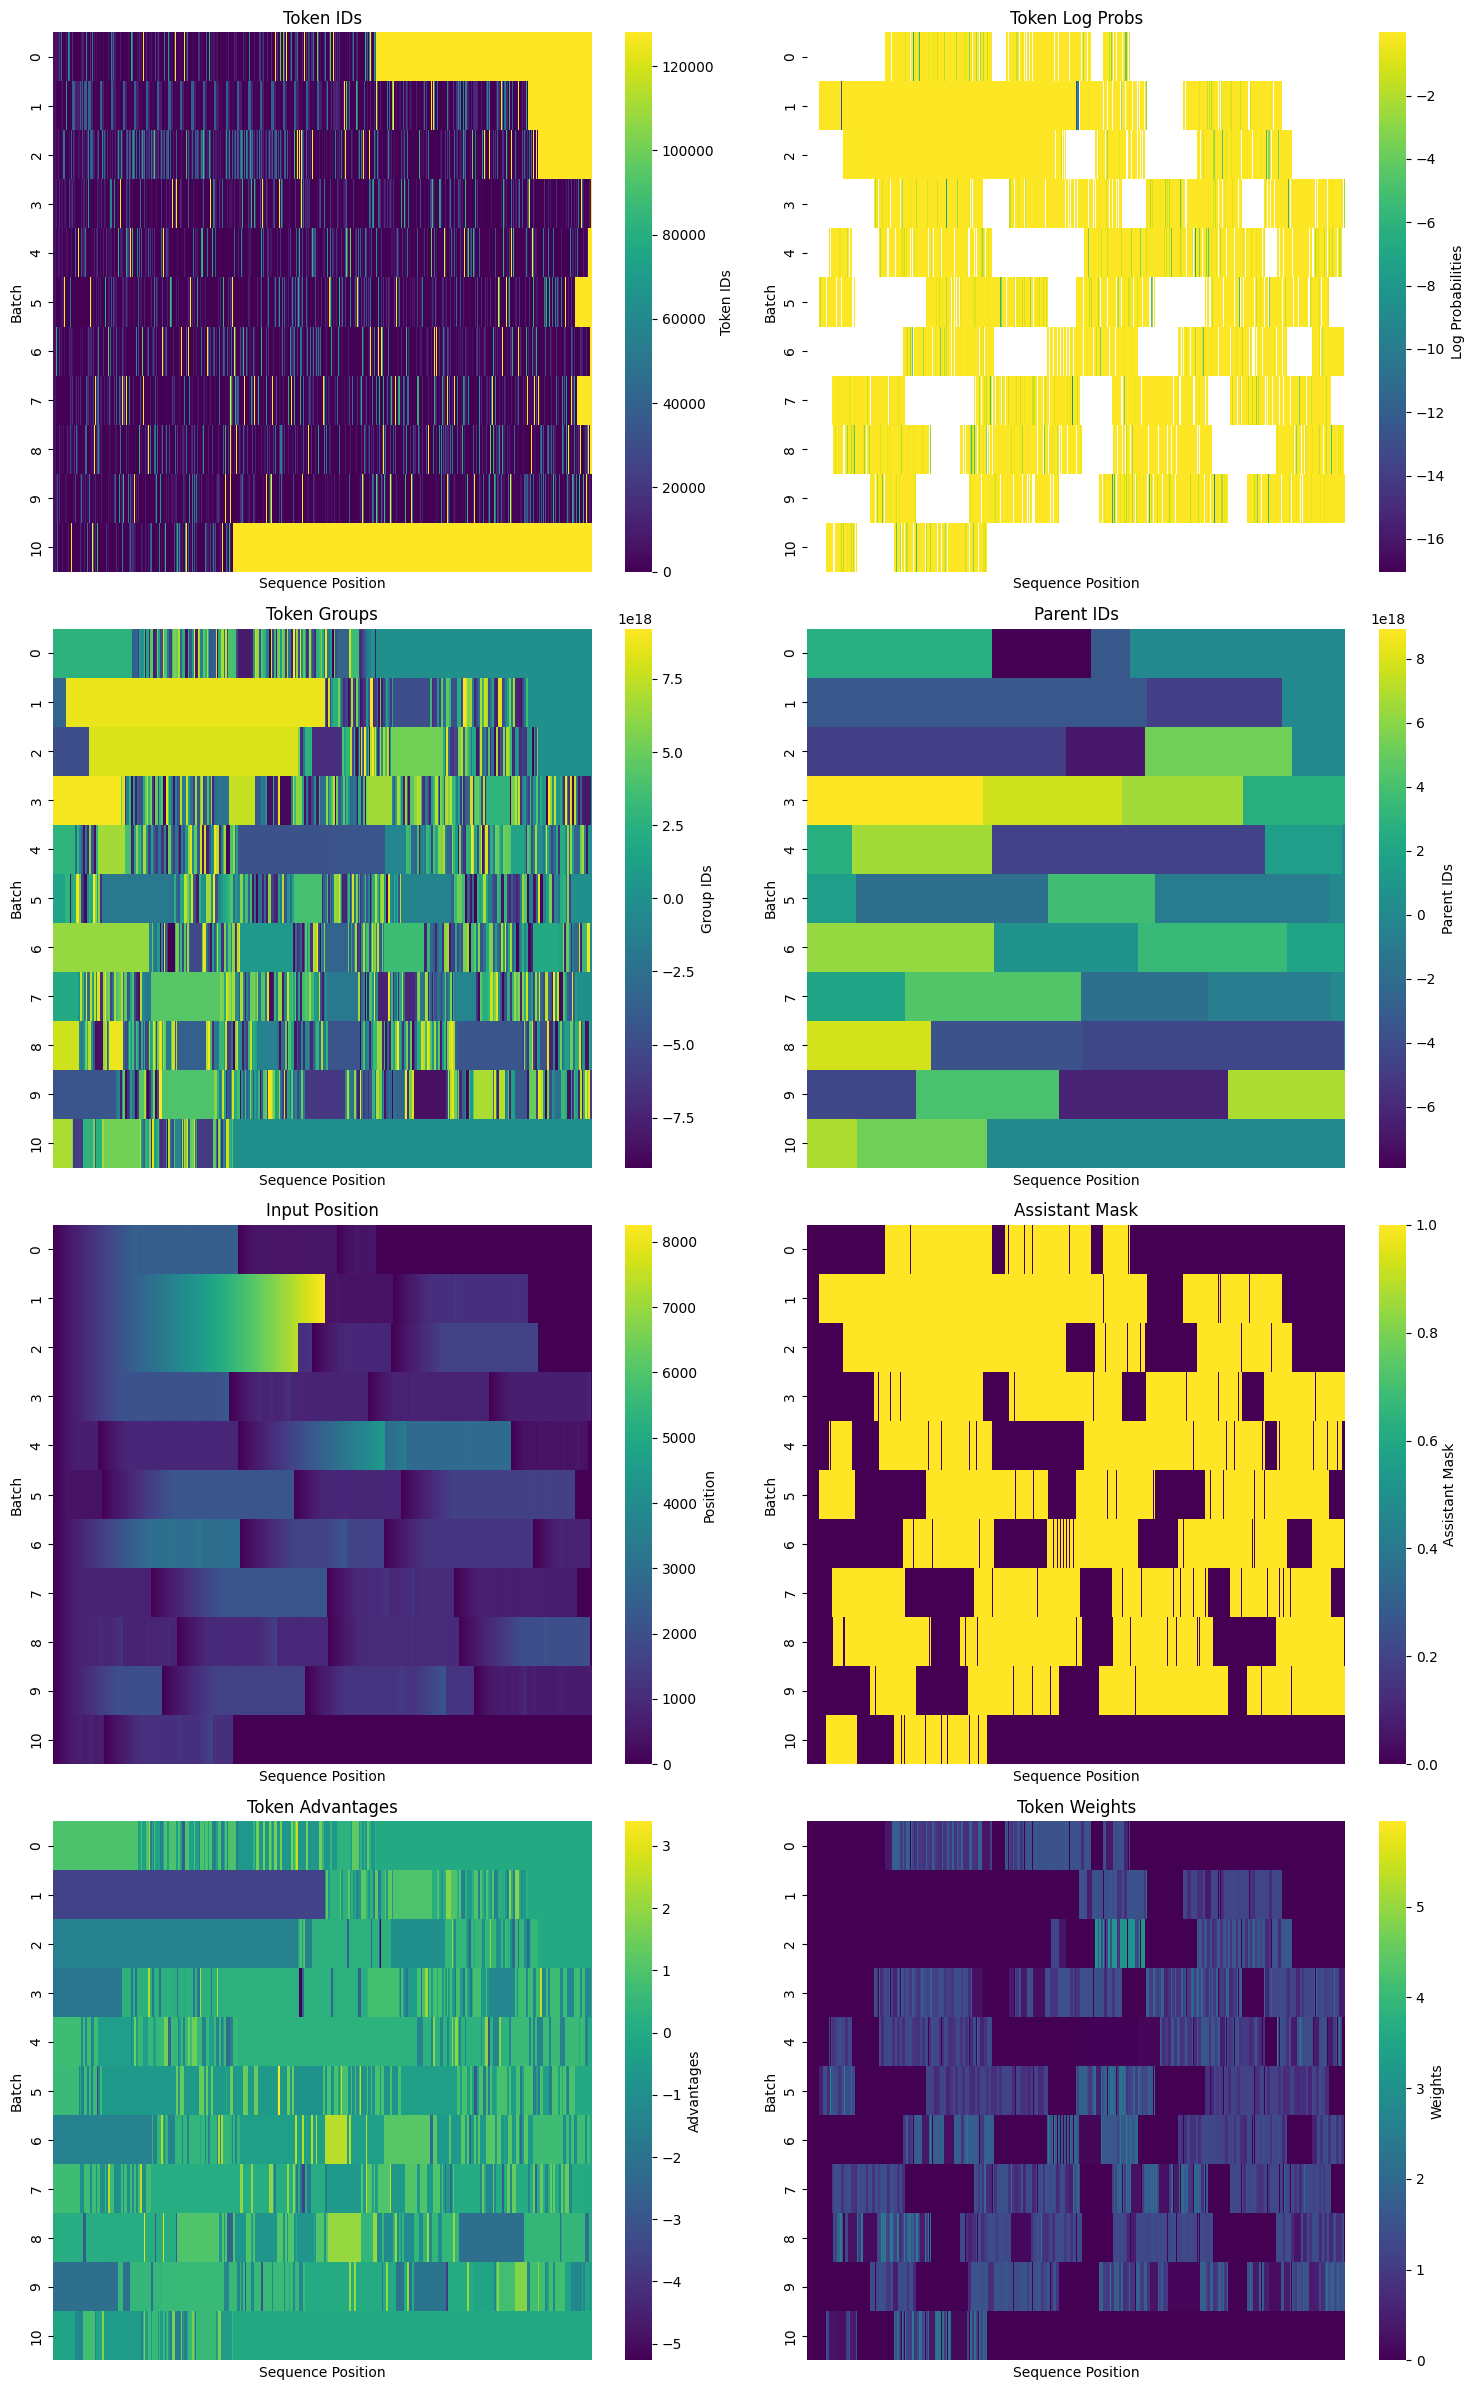

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0003
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741741019.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 17.14 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0706: 100%|██████████| 5/5 [01:26<00:00, 16.33s/it, loss=0.0706, policy=0.0706, entropy=0.16, kl_div=nan]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0004 --port=8000 --api-key=default
INFO 03-12 00:59:18 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 00:59:19 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 00:59:19 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.41it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.35it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.31it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.82it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.61it/s]



INFO 03-12 00:59:32 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 00:59:33 worker.py:267] Memory profiling takes 1.21 seconds
INFO 03-12 00:59:33 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 00:59:33 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 00:59:33 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 00:59:33 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:00:17 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.88 seconds
INFO 03-12 01:00:17 api_server.py:756] Using supplied chat template:
INFO 03-12 01:00:17 api_server.py:756] None
INFO 03-12 01:00:17 launcher.py:21] Available routes are:
INFO 03-12 01:00:17 launcher.py:29] Route: 

INFO:     Started server process [19026]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:00:18 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:47966 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [02:16<00:00,  3.73it/s, completion_tokens=90, prompt_tokens=1040, reward=0.388, acc=0.388, early_stop=0.00187, token_logprobs=297082]
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


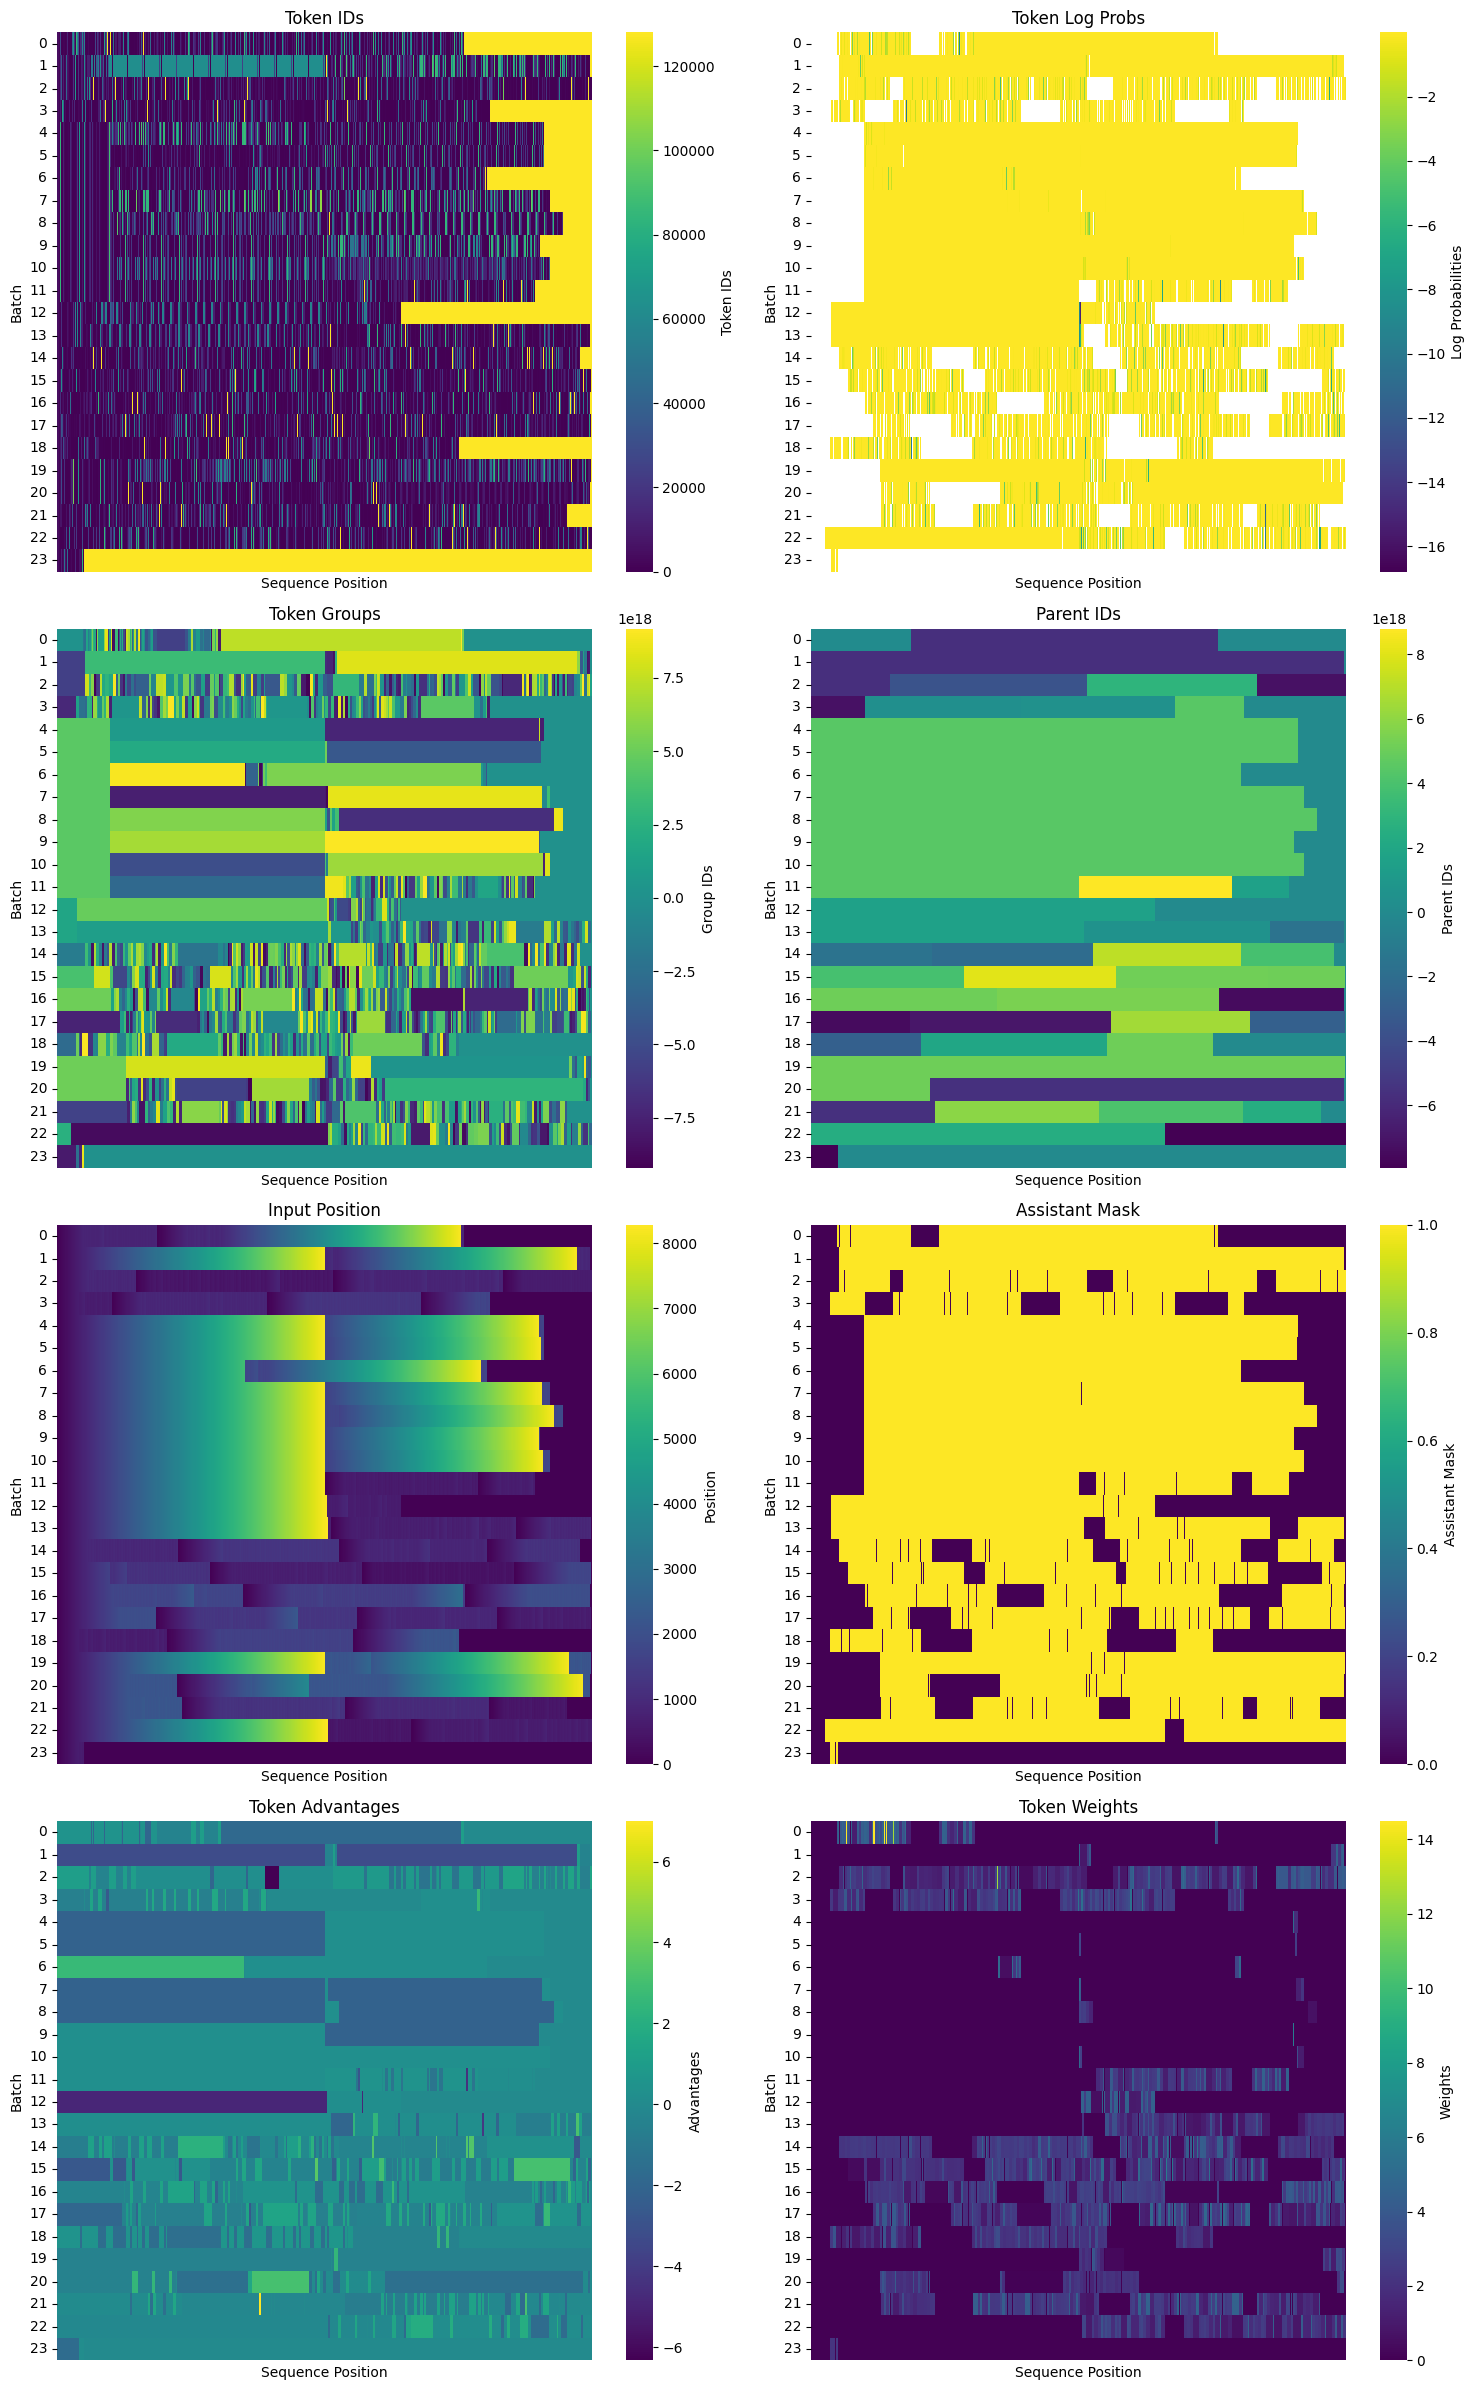

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0004
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 24
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741741376.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 17.16 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.0024: 100%|██████████| 12/12 [03:15<00:00, 15.58s/it, loss=0.00243, policy=0.00243, entropy=0.31, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INF

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0005 --port=8000 --api-key=default
INFO 03-12 01:07:04 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 01:07:05 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 01:07:05 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.48it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.39it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.39it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.92it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.69it/s]



INFO 03-12 01:07:18 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:07:19 worker.py:267] Memory profiling takes 1.15 seconds
INFO 03-12 01:07:19 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:07:19 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:07:19 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:07:19 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:08:02 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.83 seconds
INFO 03-12 01:08:02 api_server.py:756] Using supplied chat template:
INFO 03-12 01:08:02 api_server.py:756] None
INFO 03-12 01:08:02 launcher.py:21] Available routes are:
INFO 03-12 01:08:02 launcher.py:29] Route: 

INFO:     Started server process [22514]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:08:04 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:57202 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

val: 100%|██████████| 128/128 [01:43<00:00,  1.47it/s, completion_tokens=84, prompt_tokens=1129, reward=0.393, acc=0.393, early_stop=0.00781, token_logprobs=18330]
Cleared iteration directory ./models/072/0003 except chat-completion-logs
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


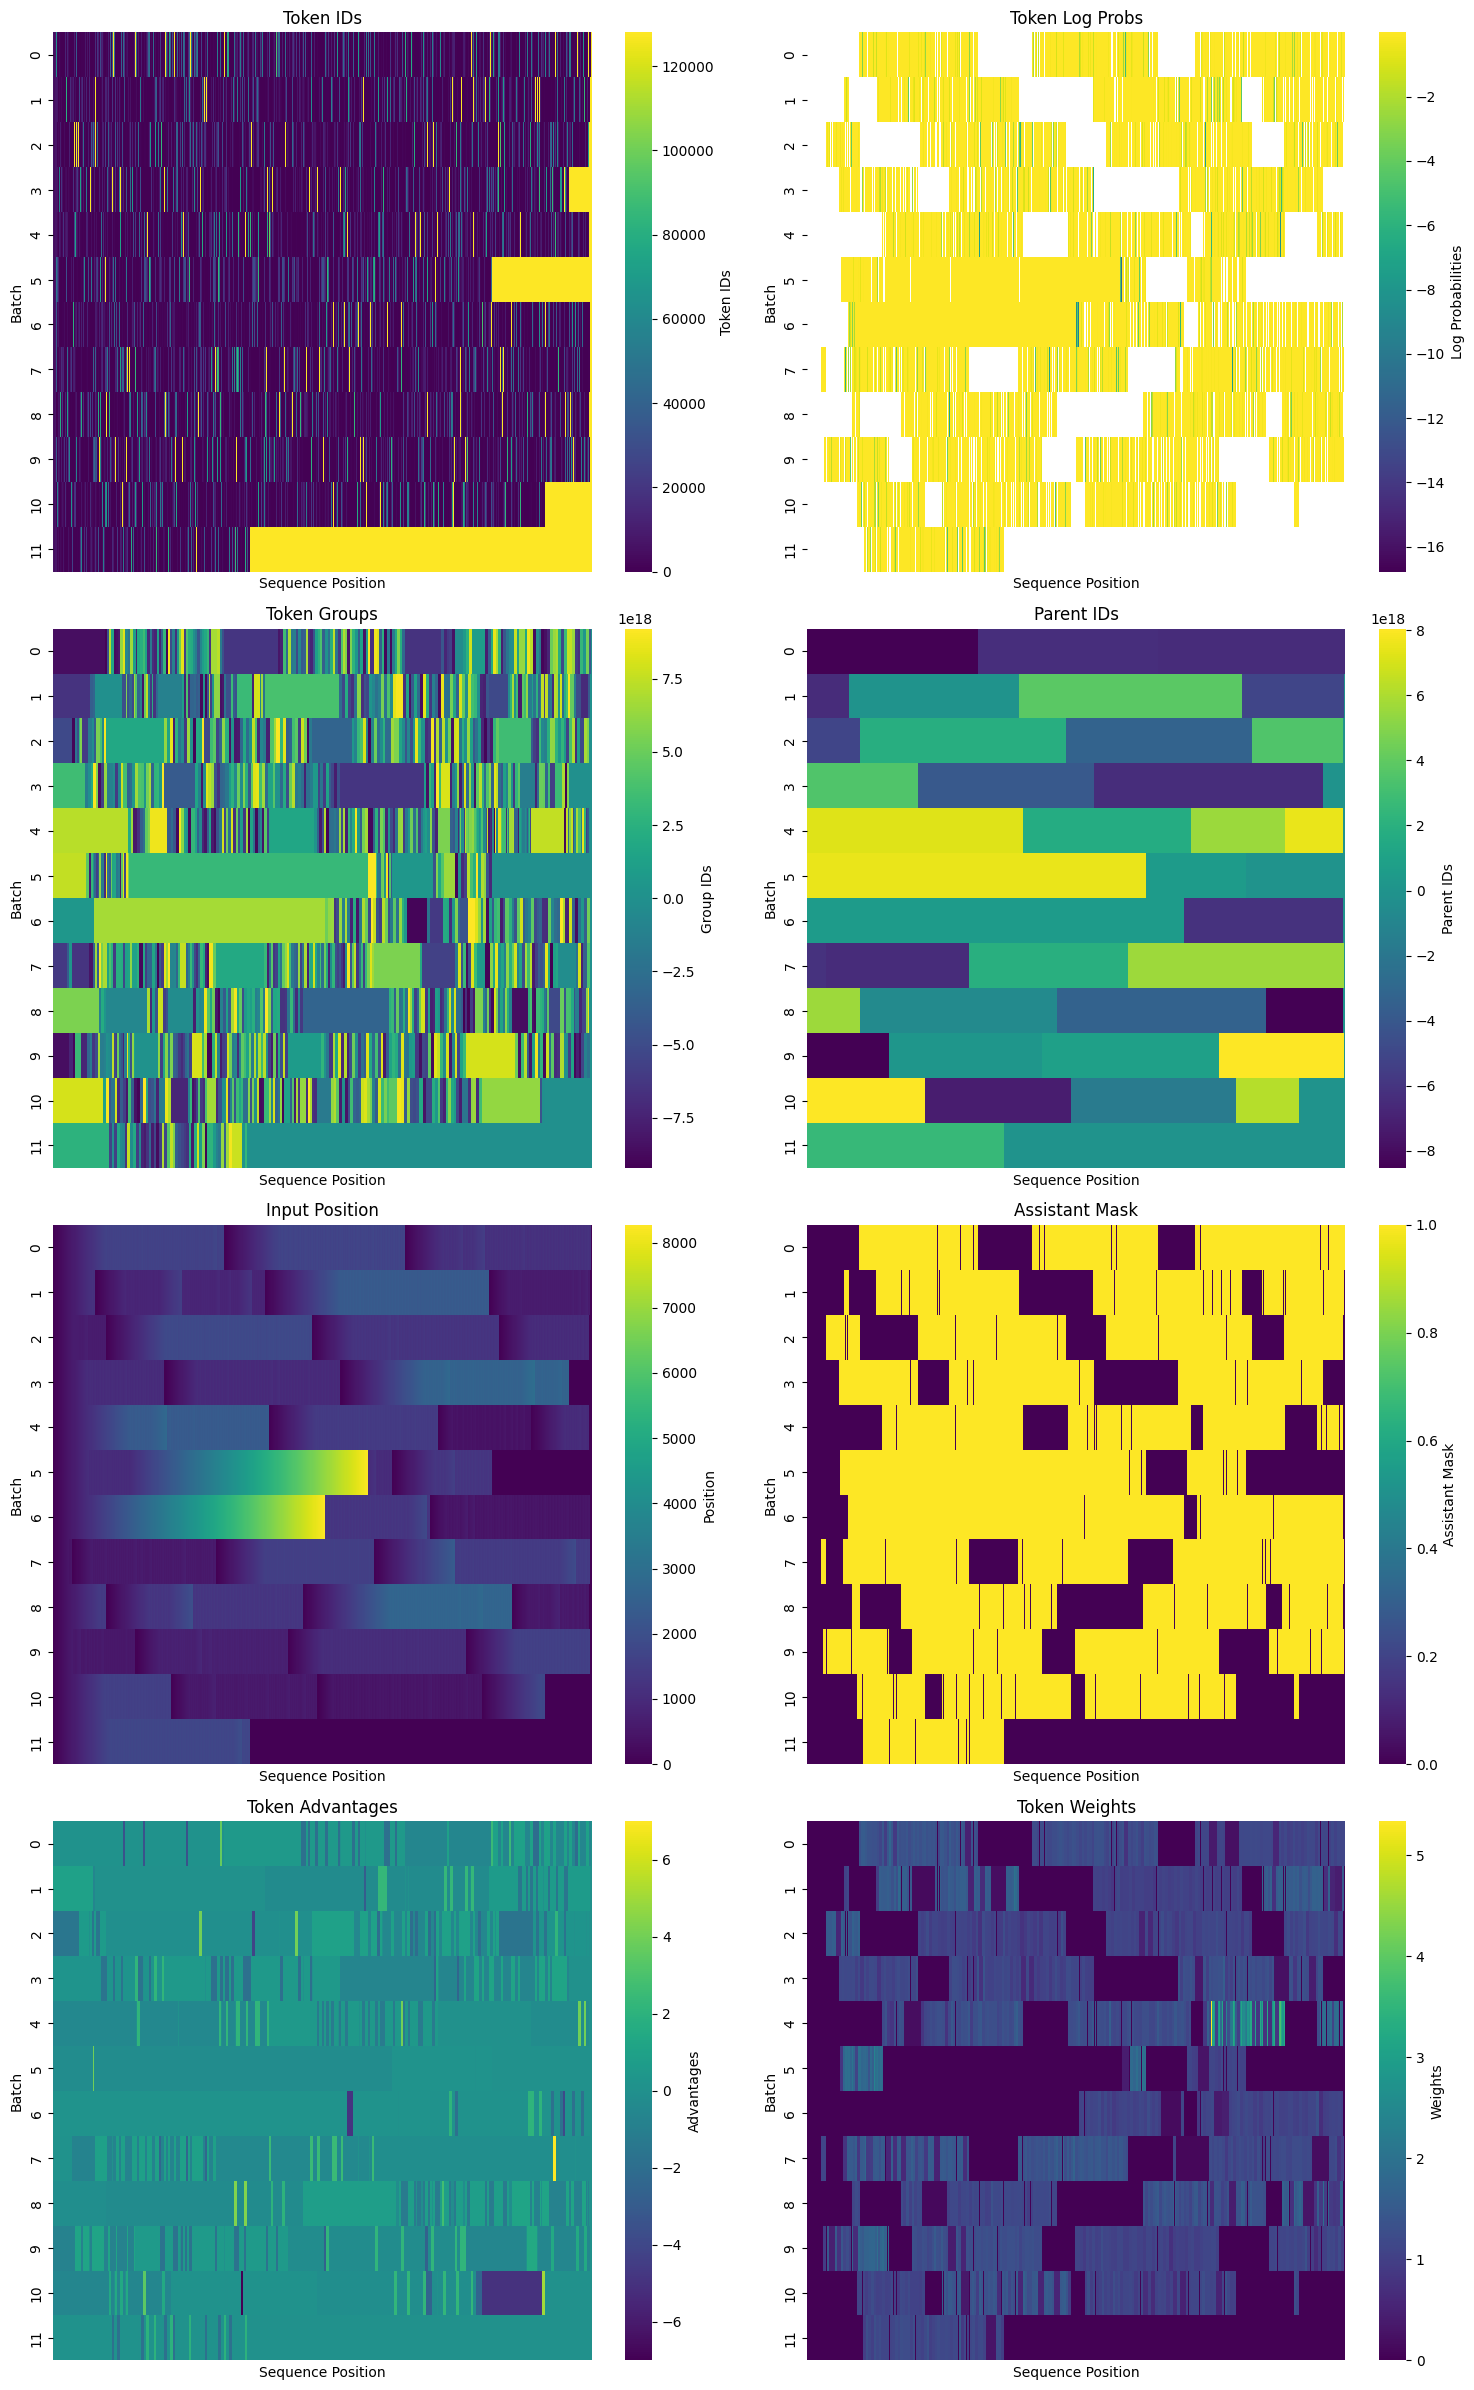

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0005
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 12
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741741809.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 16.91 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: 0.0264: 100%|██████████| 6/6 [01:42<00:00, 16.04s/it, loss=0.0264, policy=0.0264, entropy=0.127, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:to

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0006 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0006 --port=8000 --api-key=default
INFO 03-12 01:12:43 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 01:12:44 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 01:12:44 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0006', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.47it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.40it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.39it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.92it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.69it/s]



INFO 03-12 01:12:57 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:12:58 worker.py:267] Memory profiling takes 1.14 seconds
INFO 03-12 01:12:58 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:12:58 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:12:58 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:12:58 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:13:42 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.93 seconds
INFO 03-12 01:13:42 api_server.py:756] Using supplied chat template:
INFO 03-12 01:13:42 api_server.py:756] None
INFO 03-12 01:13:42 launcher.py:21] Available routes are:
INFO 03-12 01:13:42 launcher.py:29] Route: 

INFO:     Started server process [25959]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:13:43 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:41904 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [01:51<00:00,  3.89it/s, completion_tokens=83, prompt_tokens=1347, reward=0.327, acc=0.327, early_stop=0.00125, token_logprobs=183523]
Cleared iteration directory ./models/072/0004 except chat-completion-logs
Cleared iteration directory ./models/072/0003 except chat-completion-logs
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


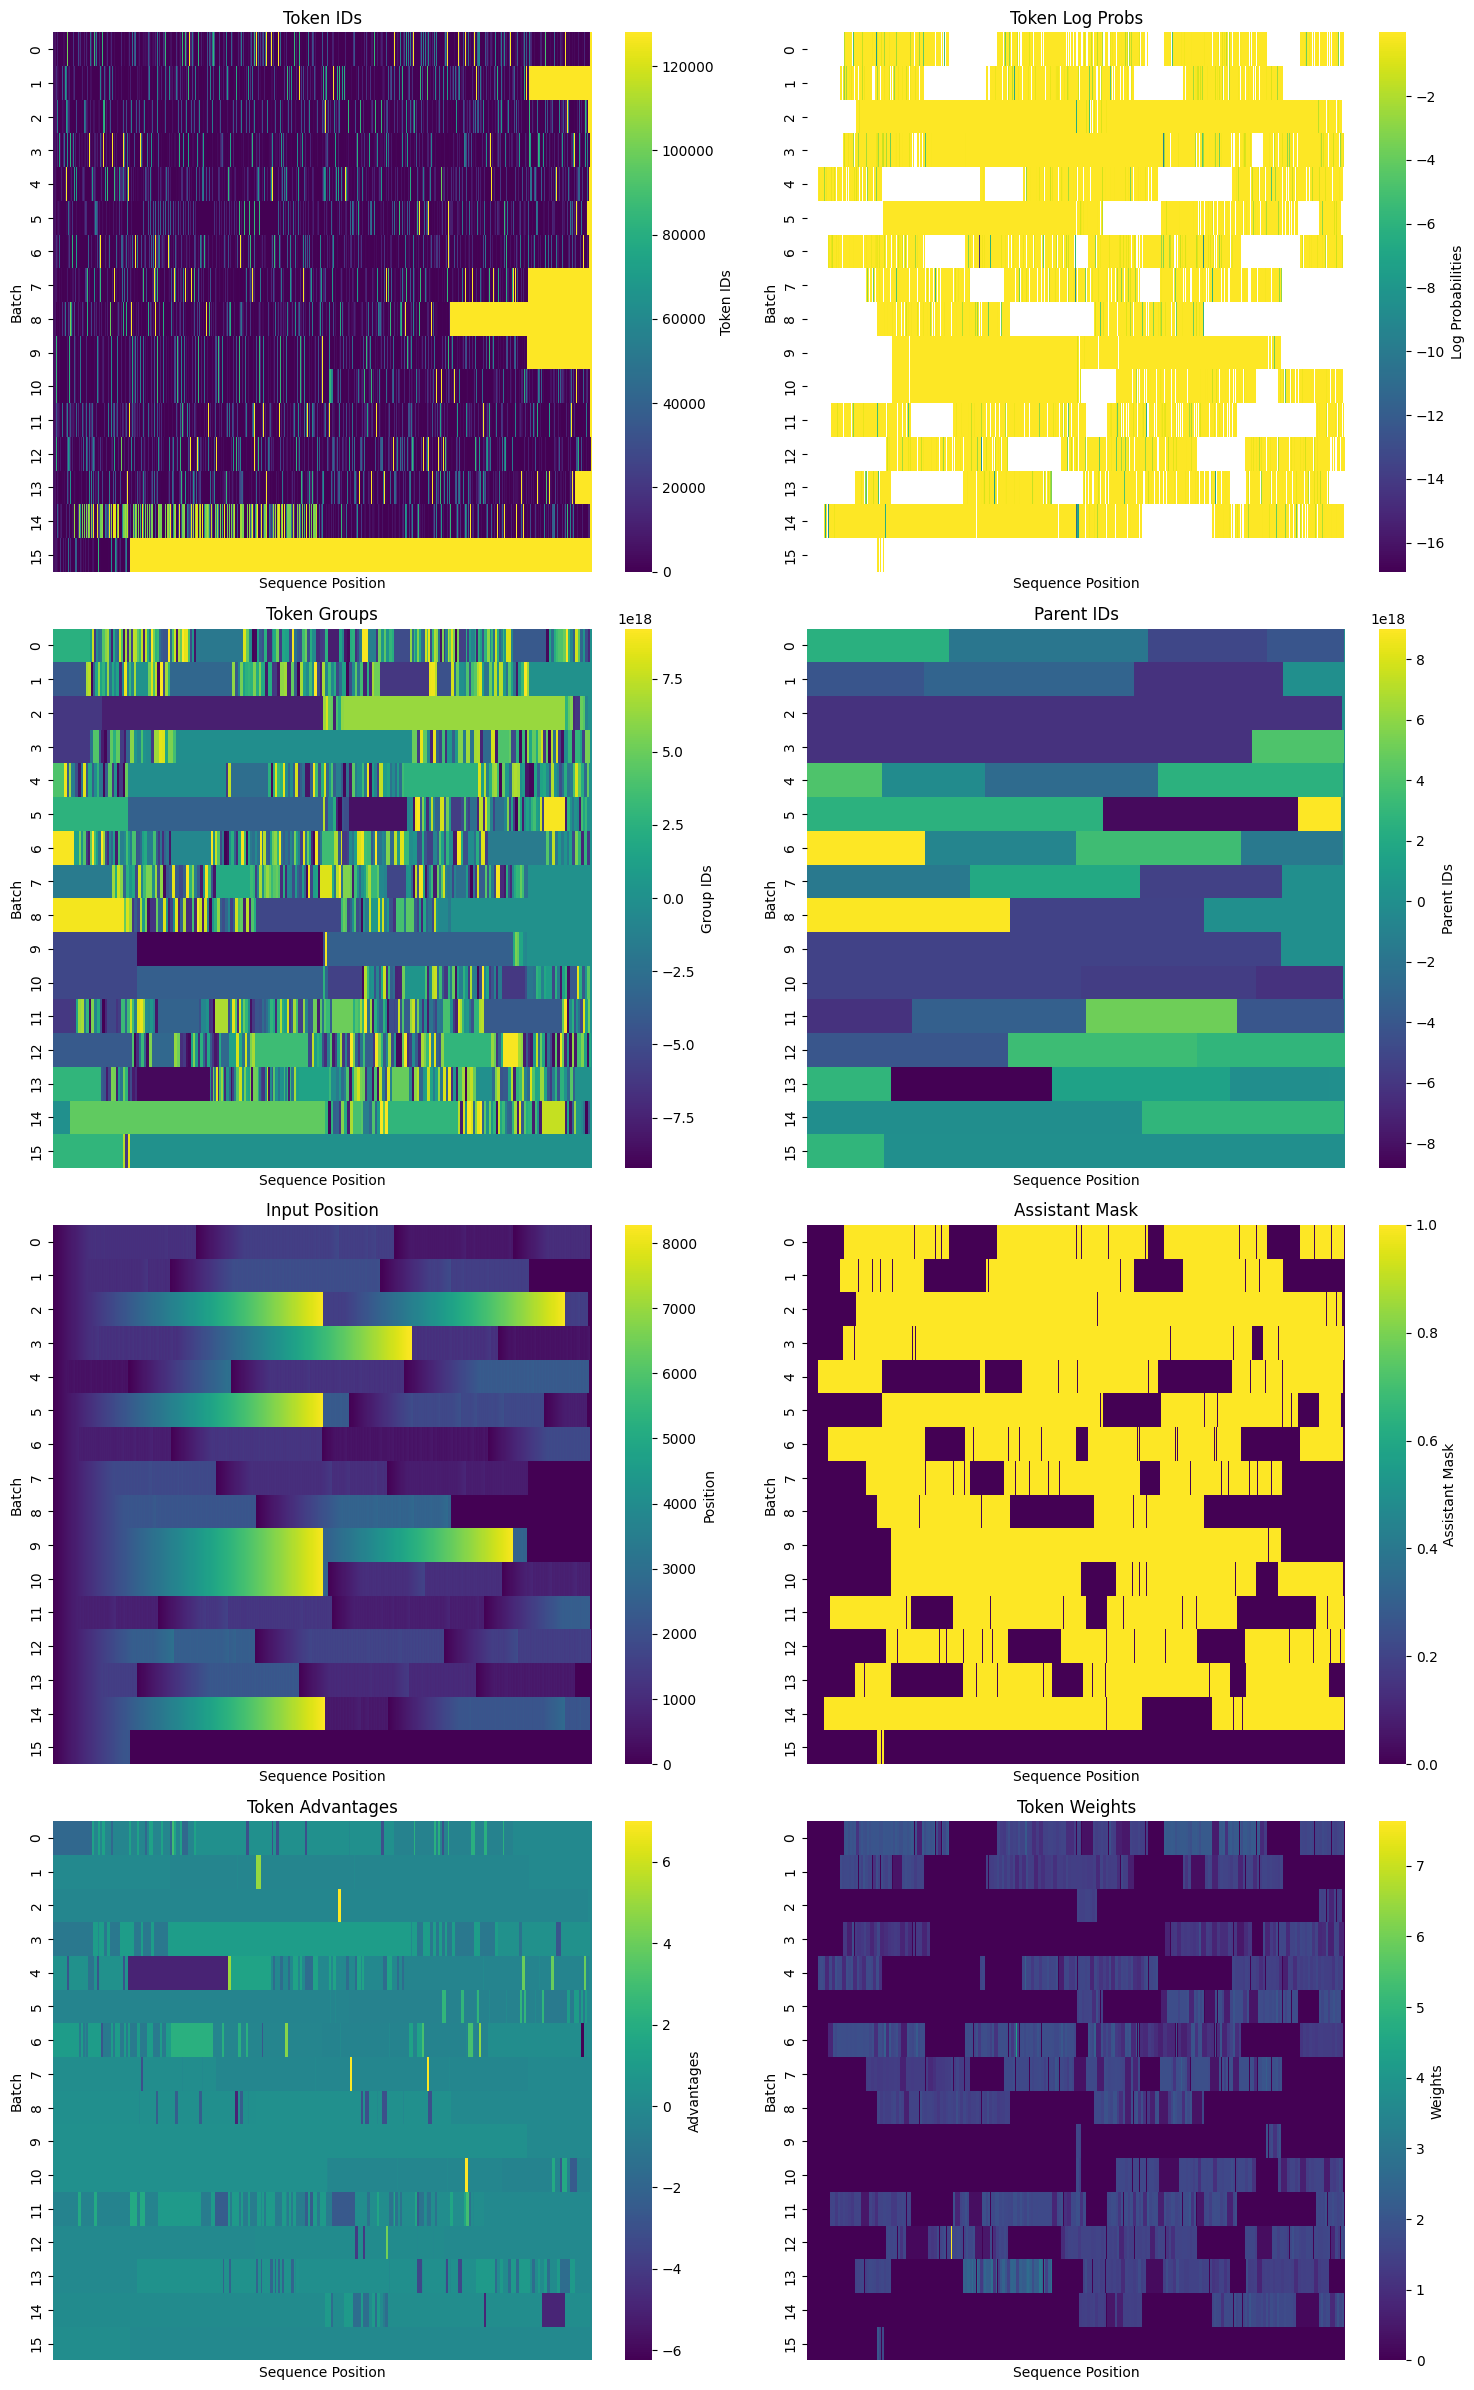

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0006
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 16
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741742156.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 16.85 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|8|Loss: 0.0181: 100%|██████████| 8/8 [02:12<00:00, 15.76s/it, loss=0.0181, policy=0.0181, entropy=0.169, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:to

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0007 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0007 --port=8000 --api-key=default
INFO 03-12 01:19:01 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 01:19:02 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 01:19:02 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0007', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.42it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.34it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.32it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.83it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.62it/s]



INFO 03-12 01:19:15 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:19:16 worker.py:267] Memory profiling takes 1.21 seconds
INFO 03-12 01:19:16 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:19:16 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:19:17 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:19:17 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:19:59 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.87 seconds
INFO 03-12 01:19:59 api_server.py:756] Using supplied chat template:
INFO 03-12 01:19:59 api_server.py:756] None
INFO 03-12 01:19:59 launcher.py:21] Available routes are:
INFO 03-12 01:19:59 launcher.py:29] Route: 

INFO:     Started server process [29405]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:20:00 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:58306 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [01:44<00:00,  7.16it/s, completion_tokens=91, prompt_tokens=1225, reward=0.322, acc=0.322, early_stop=0.00125, token_logprobs=160210]
Cleared iteration directory ./models/072/0006 except chat-completion-logs
Cleared iteration directory ./models/072/0004 except chat-completion-logs
Cleared iteration directory ./models/072/0003 except chat-completion-logs
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


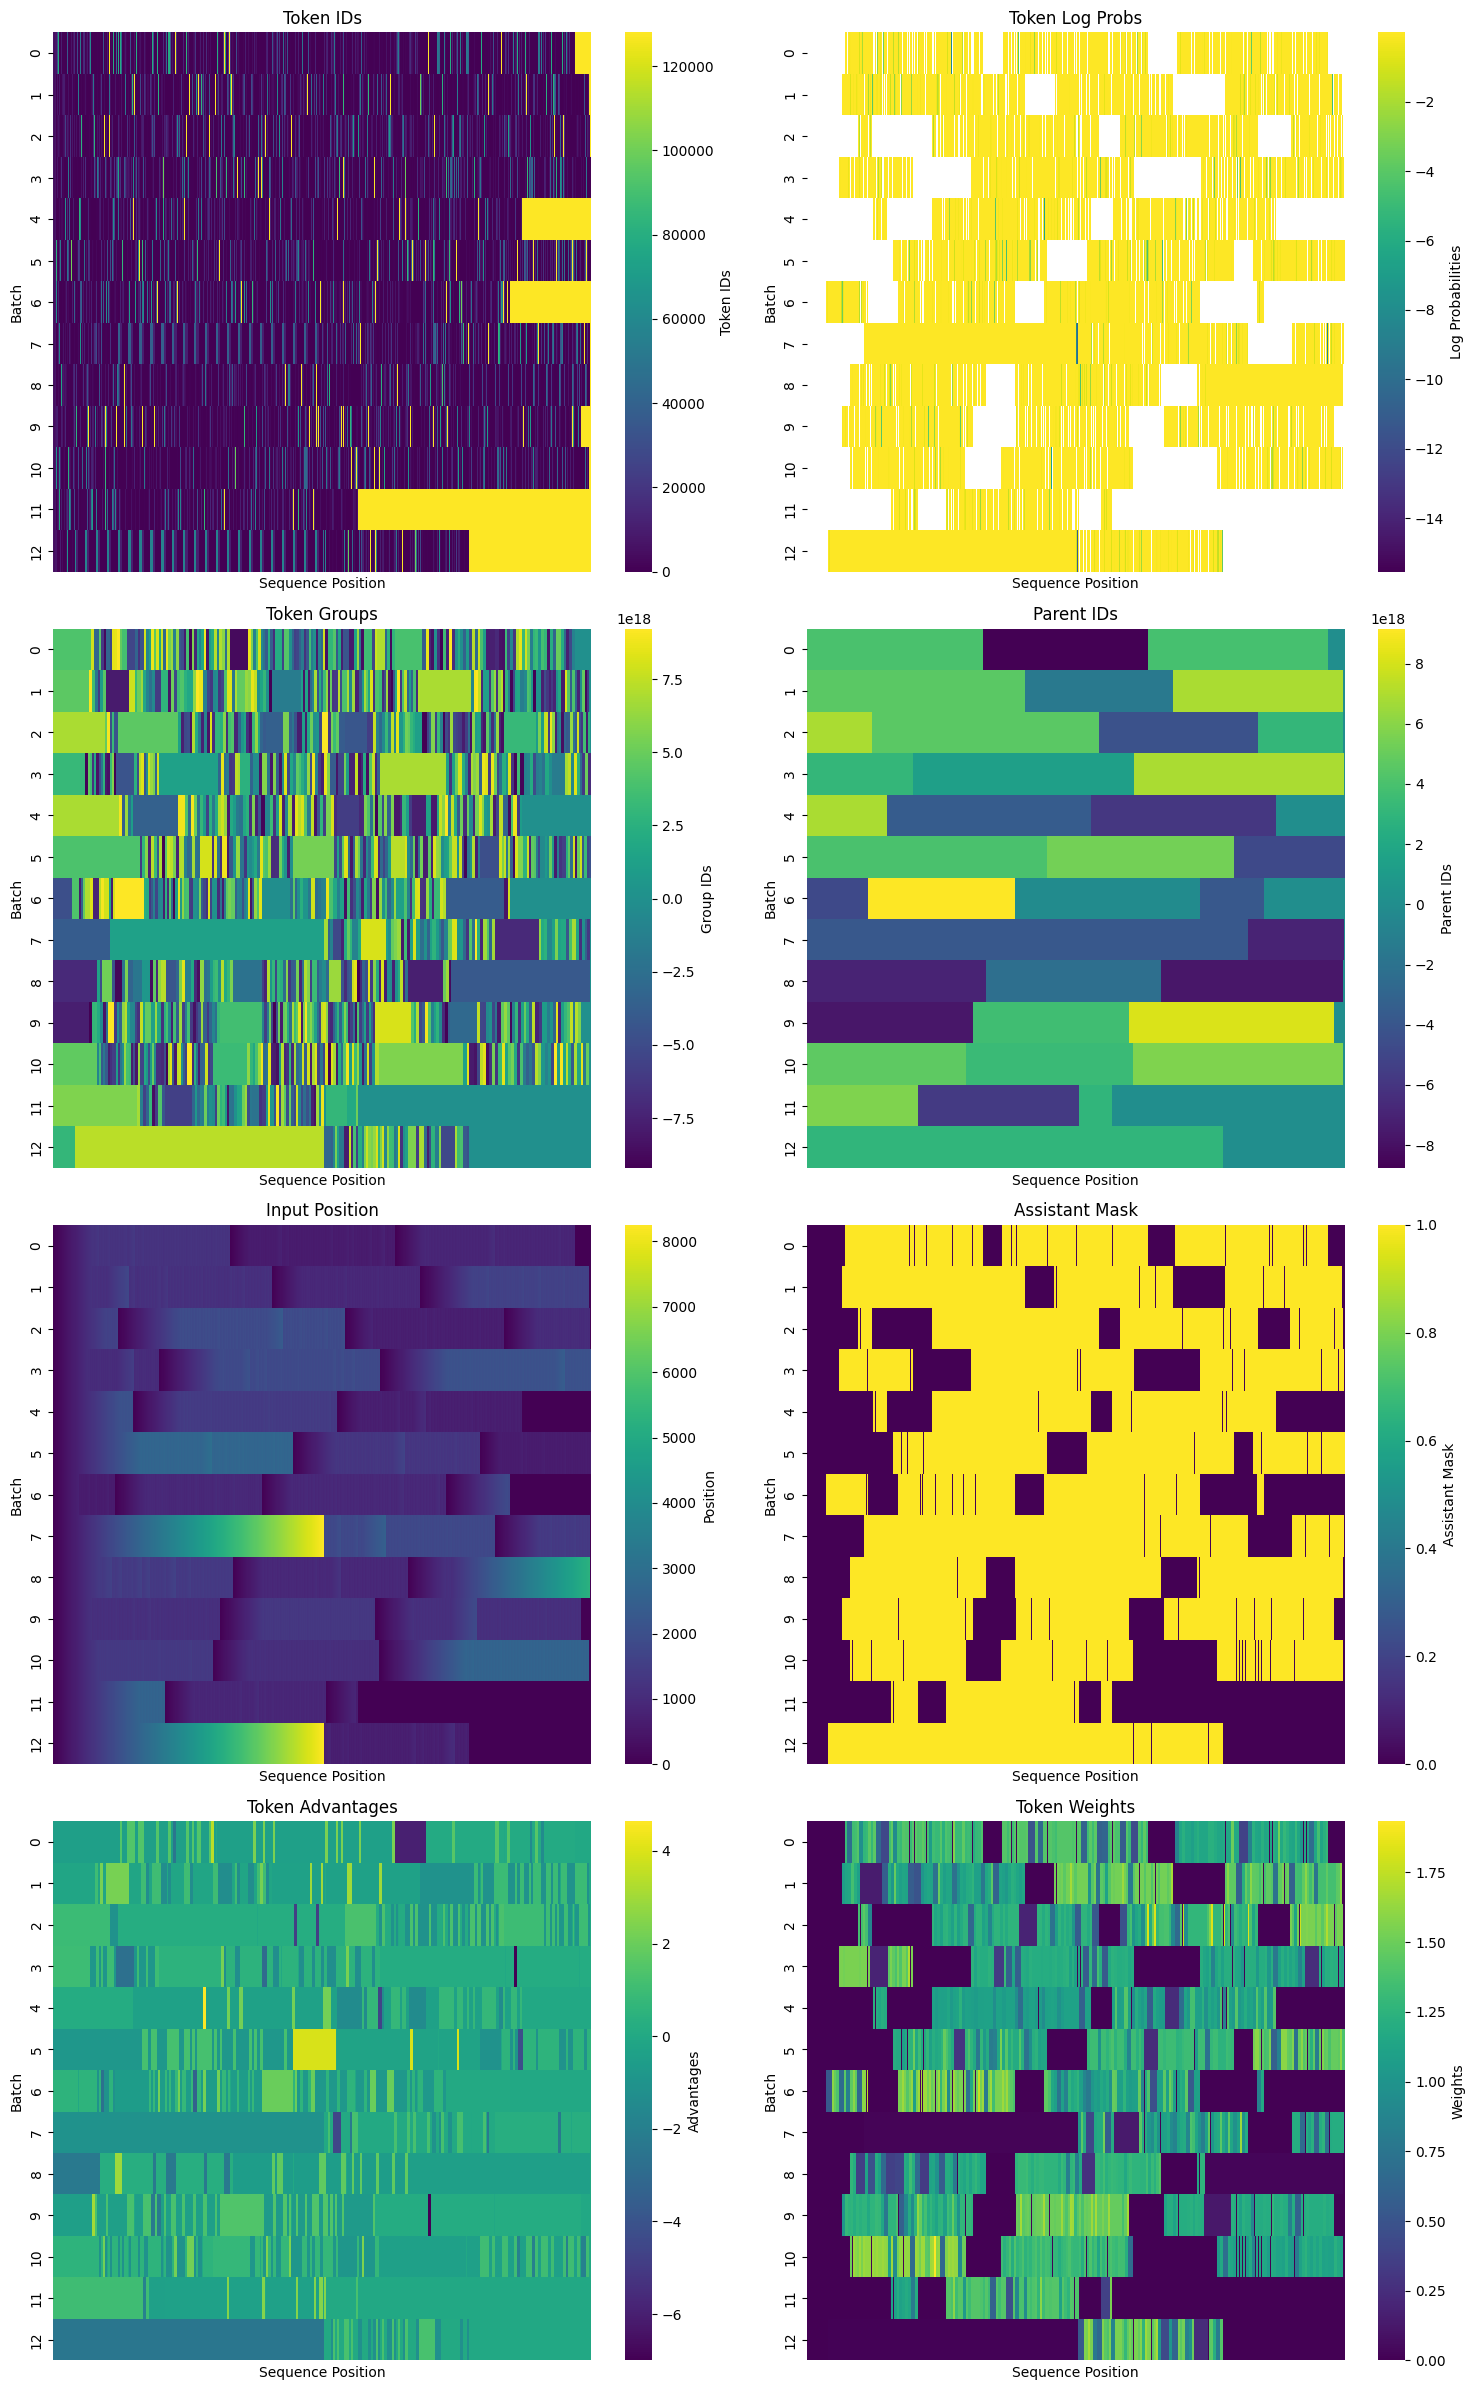

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0007
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 13
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741742525.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 16.85 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: 0.0517: 100%|██████████| 6/6 [01:42<00:00, 16.06s/it, loss=0.0517, policy=0.0517, entropy=0.115, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:to

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0008 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0008 --port=8000 --api-key=default
INFO 03-12 01:24:39 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 01:24:40 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 01:24:40 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0008', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.47it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.39it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.38it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.91it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.69it/s]



INFO 03-12 01:24:53 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:24:54 worker.py:267] Memory profiling takes 1.15 seconds
INFO 03-12 01:24:54 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:24:54 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:24:54 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:24:54 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:25:37 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.87 seconds
INFO 03-12 01:25:37 api_server.py:756] Using supplied chat template:
INFO 03-12 01:25:37 api_server.py:756] None
INFO 03-12 01:25:37 launcher.py:21] Available routes are:
INFO 03-12 01:25:37 launcher.py:29] Route: 

INFO:     Started server process [32854]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:25:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:60546 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [01:23<00:00,  8.17it/s, completion_tokens=84, prompt_tokens=1116, reward=0.247, acc=0.247, early_stop=0.000625, token_logprobs=140290]
Cleared iteration directory ./models/072/0007 except chat-completion-logs
Cleared iteration directory ./models/072/0006 except chat-completion-logs
Cleared iteration directory ./models/072/0004 except chat-completion-logs
Cleared iteration directory ./models/072/0003 except chat-completion-logs
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


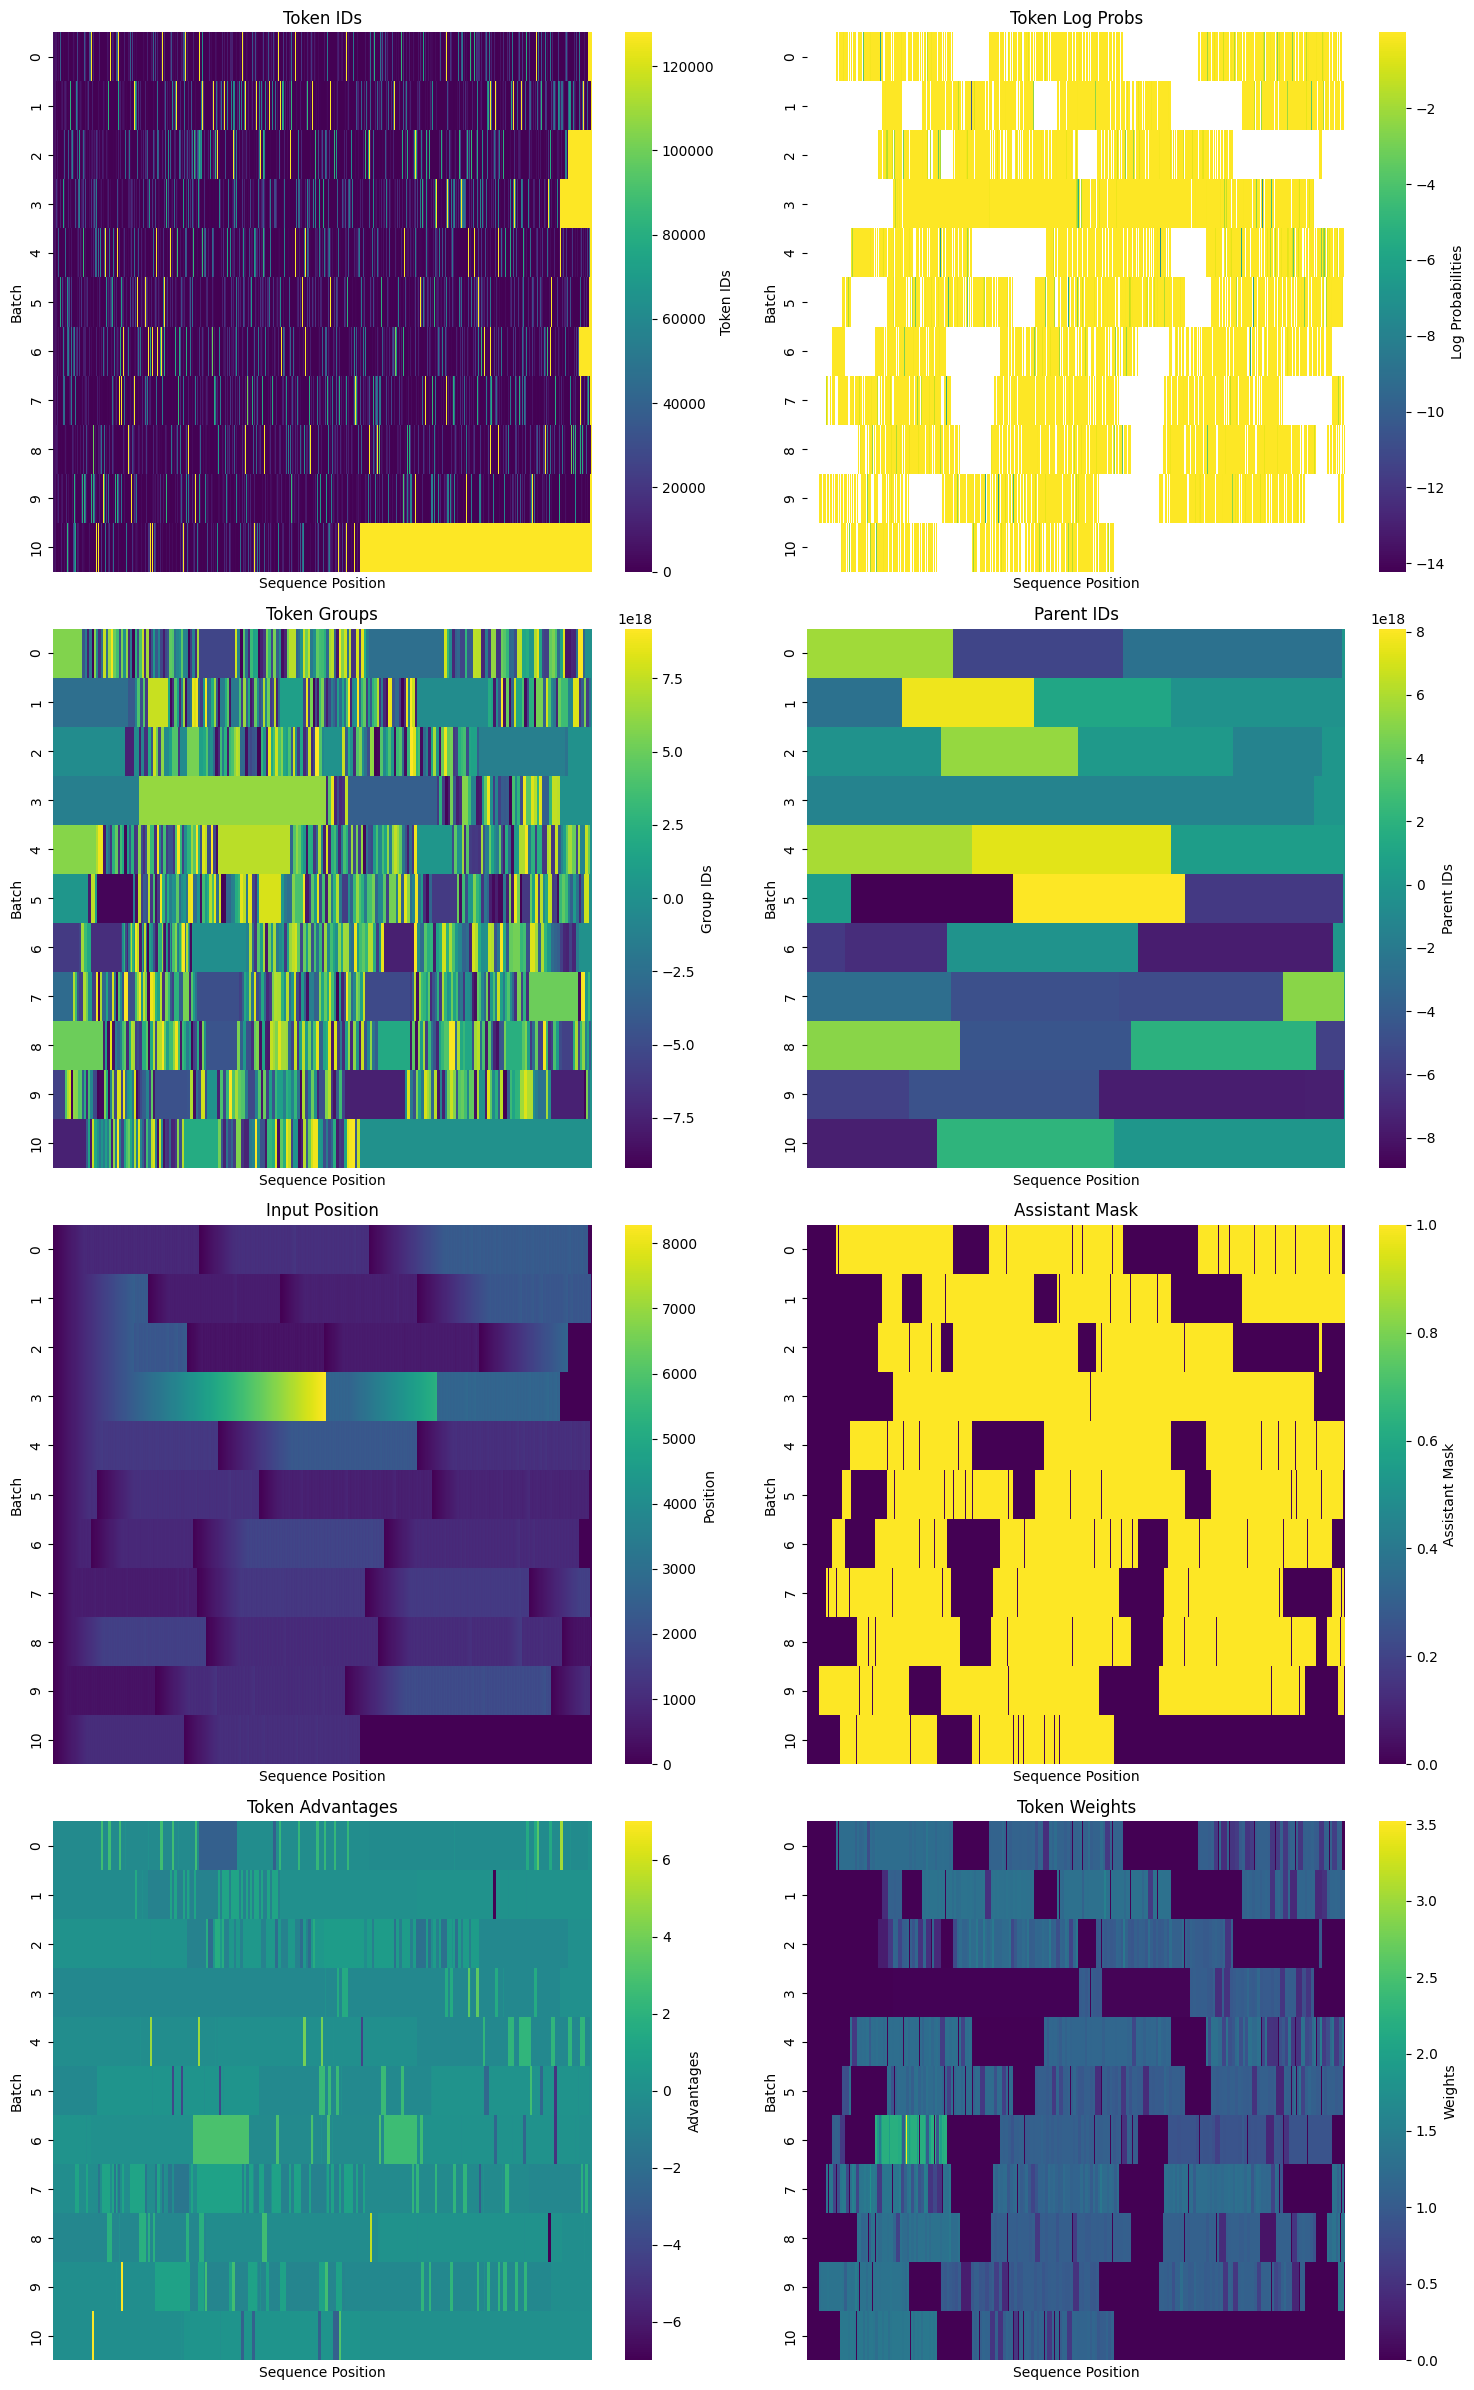

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0008
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741742843.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 17.10 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0263: 100%|██████████| 5/5 [01:26<00:00, 16.35s/it, loss=0.0263, policy=0.0263, entropy=0.0576, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:t

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0009 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0009 --port=8000 --api-key=default
INFO 03-12 01:29:42 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 01:29:43 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 01:29:43 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0009', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.48it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.40it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.39it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.91it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.69it/s]



INFO 03-12 01:29:55 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:29:57 worker.py:267] Memory profiling takes 1.16 seconds
INFO 03-12 01:29:57 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:29:57 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:29:57 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:29:57 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:30:39 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.72 seconds
INFO 03-12 01:30:40 api_server.py:756] Using supplied chat template:
INFO 03-12 01:30:40 api_server.py:756] None
INFO 03-12 01:30:40 launcher.py:21] Available routes are:
INFO 03-12 01:30:40 launcher.py:29] Route: 

INFO:     Started server process [36310]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:30:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:48060 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [01:51<00:00,  5.77it/s, completion_tokens=108, prompt_tokens=1217, reward=0.28, acc=0.28, early_stop=0.00187, token_logprobs=224408]
Cleared iteration directory ./models/072/0008 except chat-completion-logs
Cleared iteration directory ./models/072/0007 except chat-completion-logs
Cleared iteration directory ./models/072/0006 except chat-completion-logs
Cleared iteration directory ./models/072/0004 except chat-completion-logs
Cleared iteration directory ./models/072/0003 except chat-completion-logs
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


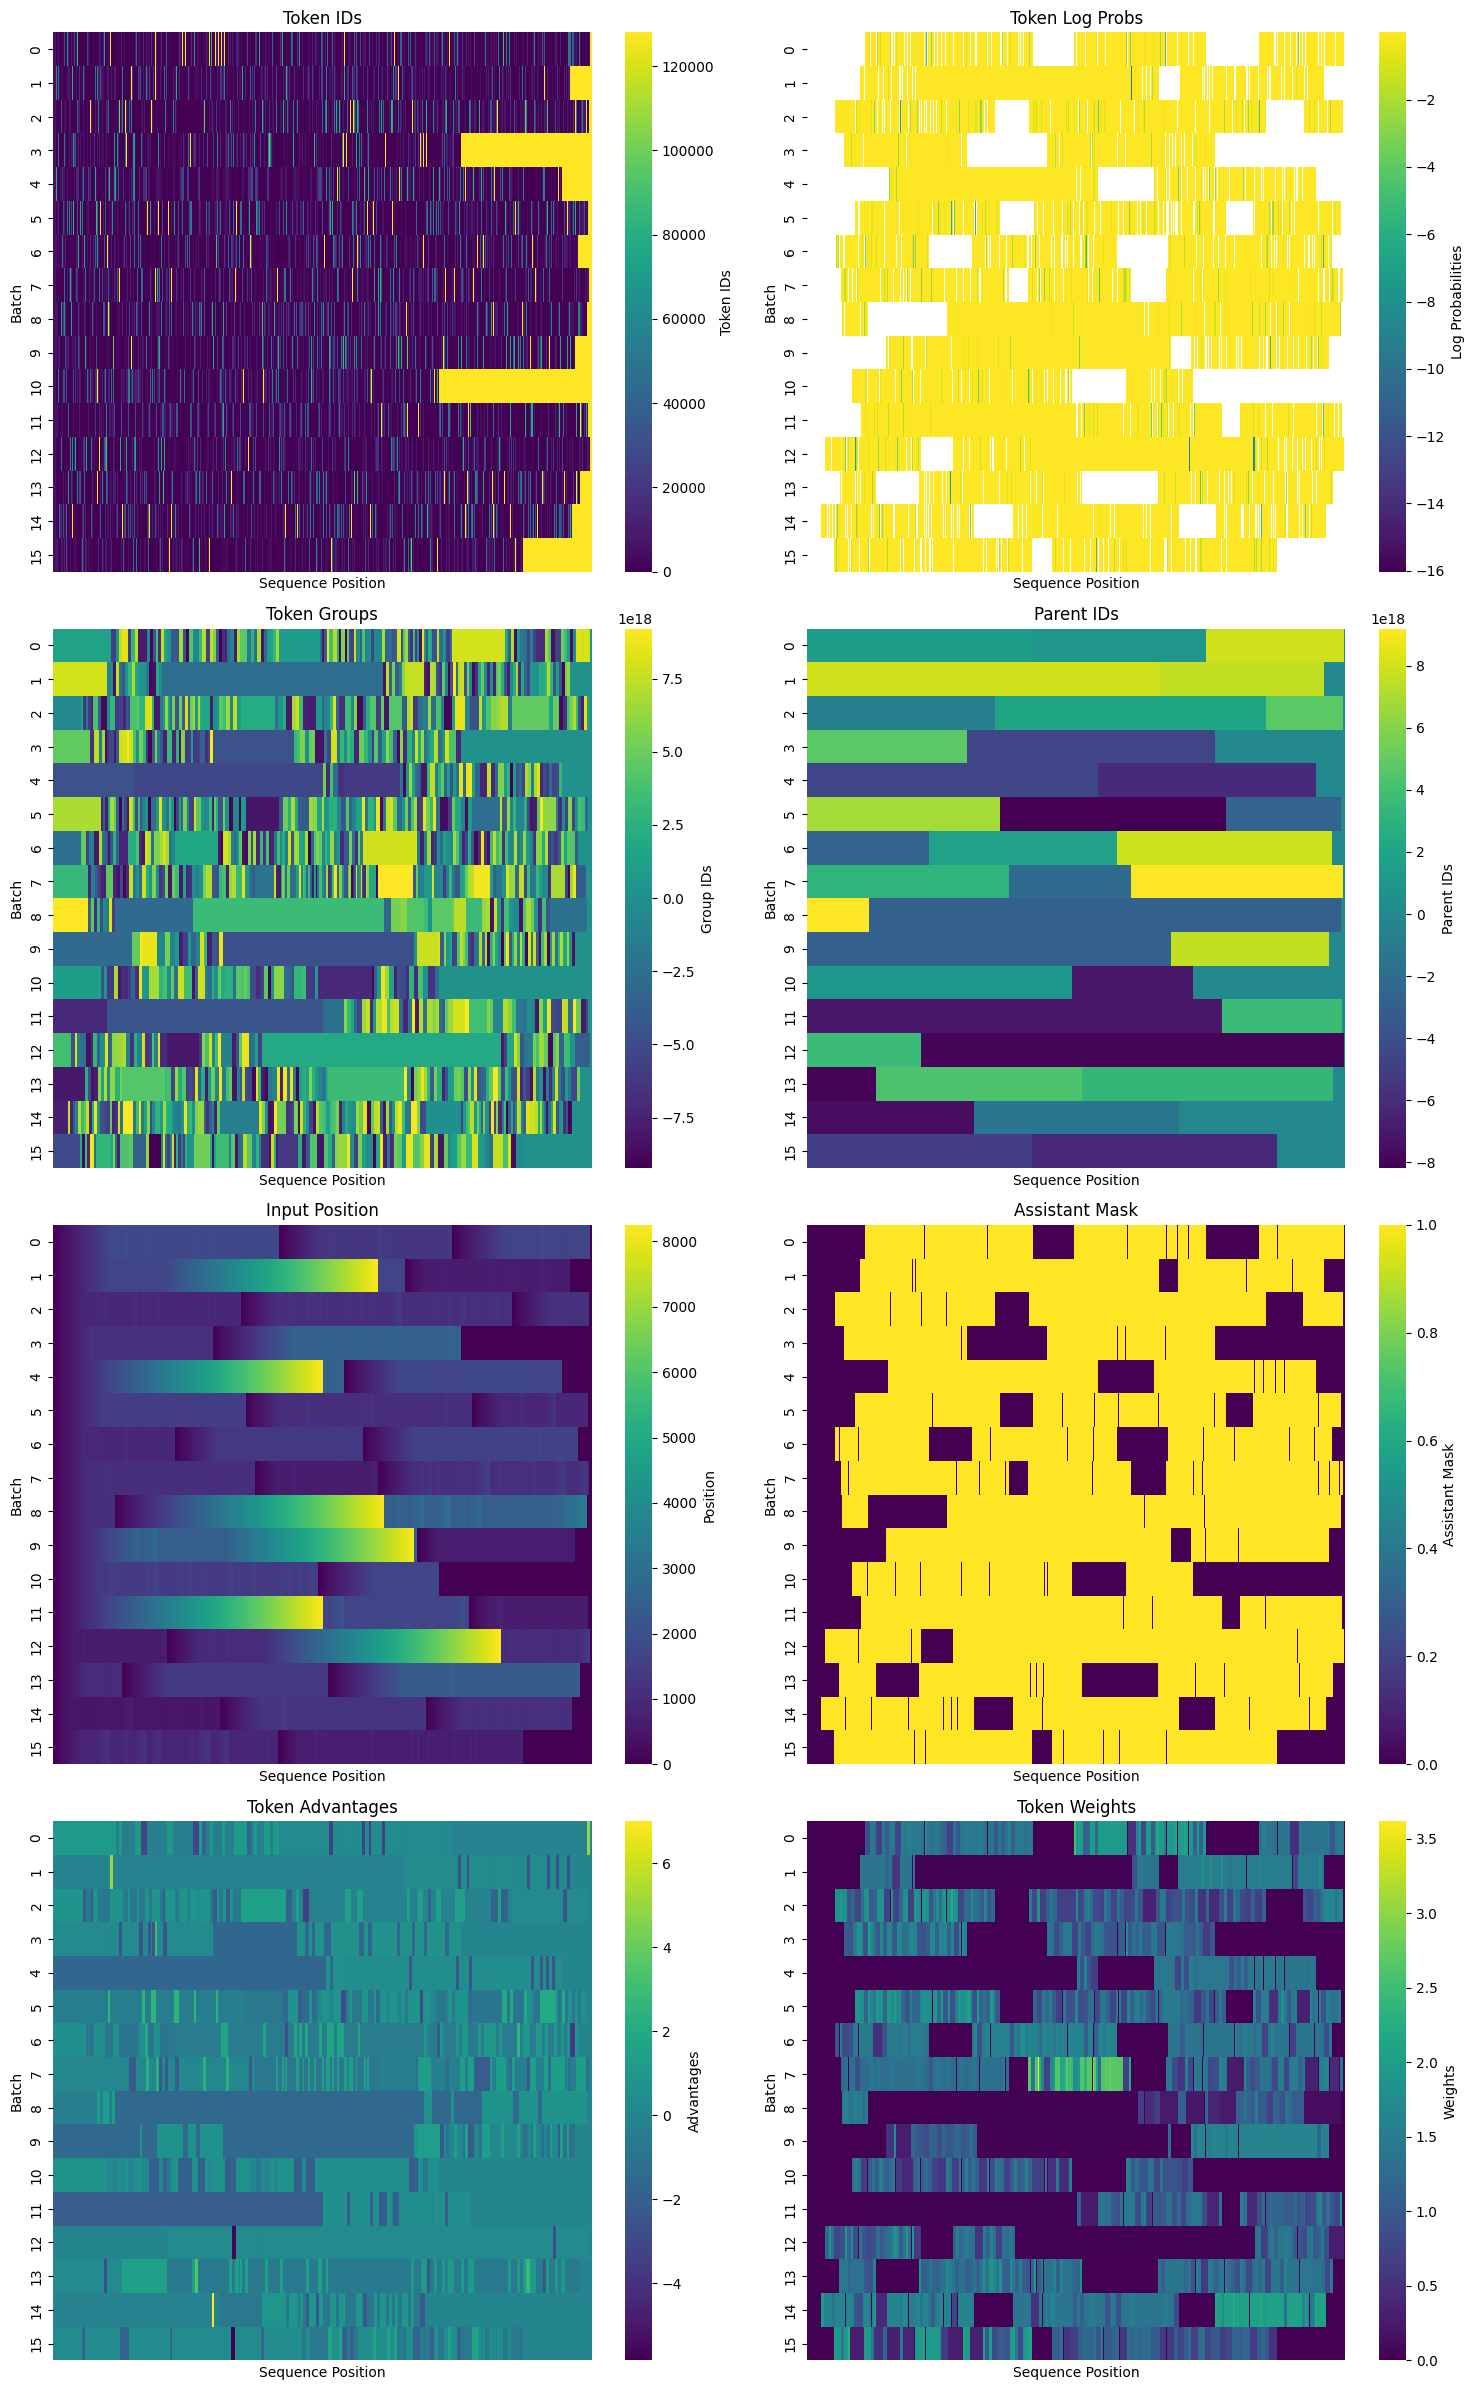

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0009
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 16
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741743174.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 17.14 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|8|Loss: 0.0120: 100%|██████████| 8/8 [02:13<00:00, 15.82s/it, loss=0.012, policy=0.012, entropy=0.0419, kl_div=nan] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:to

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0010 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0010 --port=8000 --api-key=default
INFO 03-12 01:36:00 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 01:36:01 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 01:36:01 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0010', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.49it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.41it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.39it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.92it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.70it/s]



INFO 03-12 01:36:14 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:36:15 worker.py:267] Memory profiling takes 1.16 seconds
INFO 03-12 01:36:15 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:36:15 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:36:15 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:36:15 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:36:58 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.46 seconds
INFO 03-12 01:36:59 api_server.py:756] Using supplied chat template:
INFO 03-12 01:36:59 api_server.py:756] None
INFO 03-12 01:36:59 launcher.py:21] Available routes are:
INFO 03-12 01:36:59 launcher.py:29] Route: 

INFO:     Started server process [39784]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:37:00 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:53610 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

val: 100%|██████████| 128/128 [01:47<00:00,  1.06it/s, completion_tokens=84, prompt_tokens=1124, reward=0.281, acc=0.281, early_stop=0.00781, token_logprobs=24733]
Cleared iteration directory ./models/072/0009 except chat-completion-logs
Cleared iteration directory ./models/072/0008 except chat-completion-logs
Cleared iteration directory ./models/072/0007 except chat-completion-logs
Cleared iteration directory ./models/072/0006 except chat-completion-logs
Cleared iteration directory ./models/072/0004 except chat-completion-logs
Cleared iteration directory ./models/072/0003 except chat-completion-logs
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


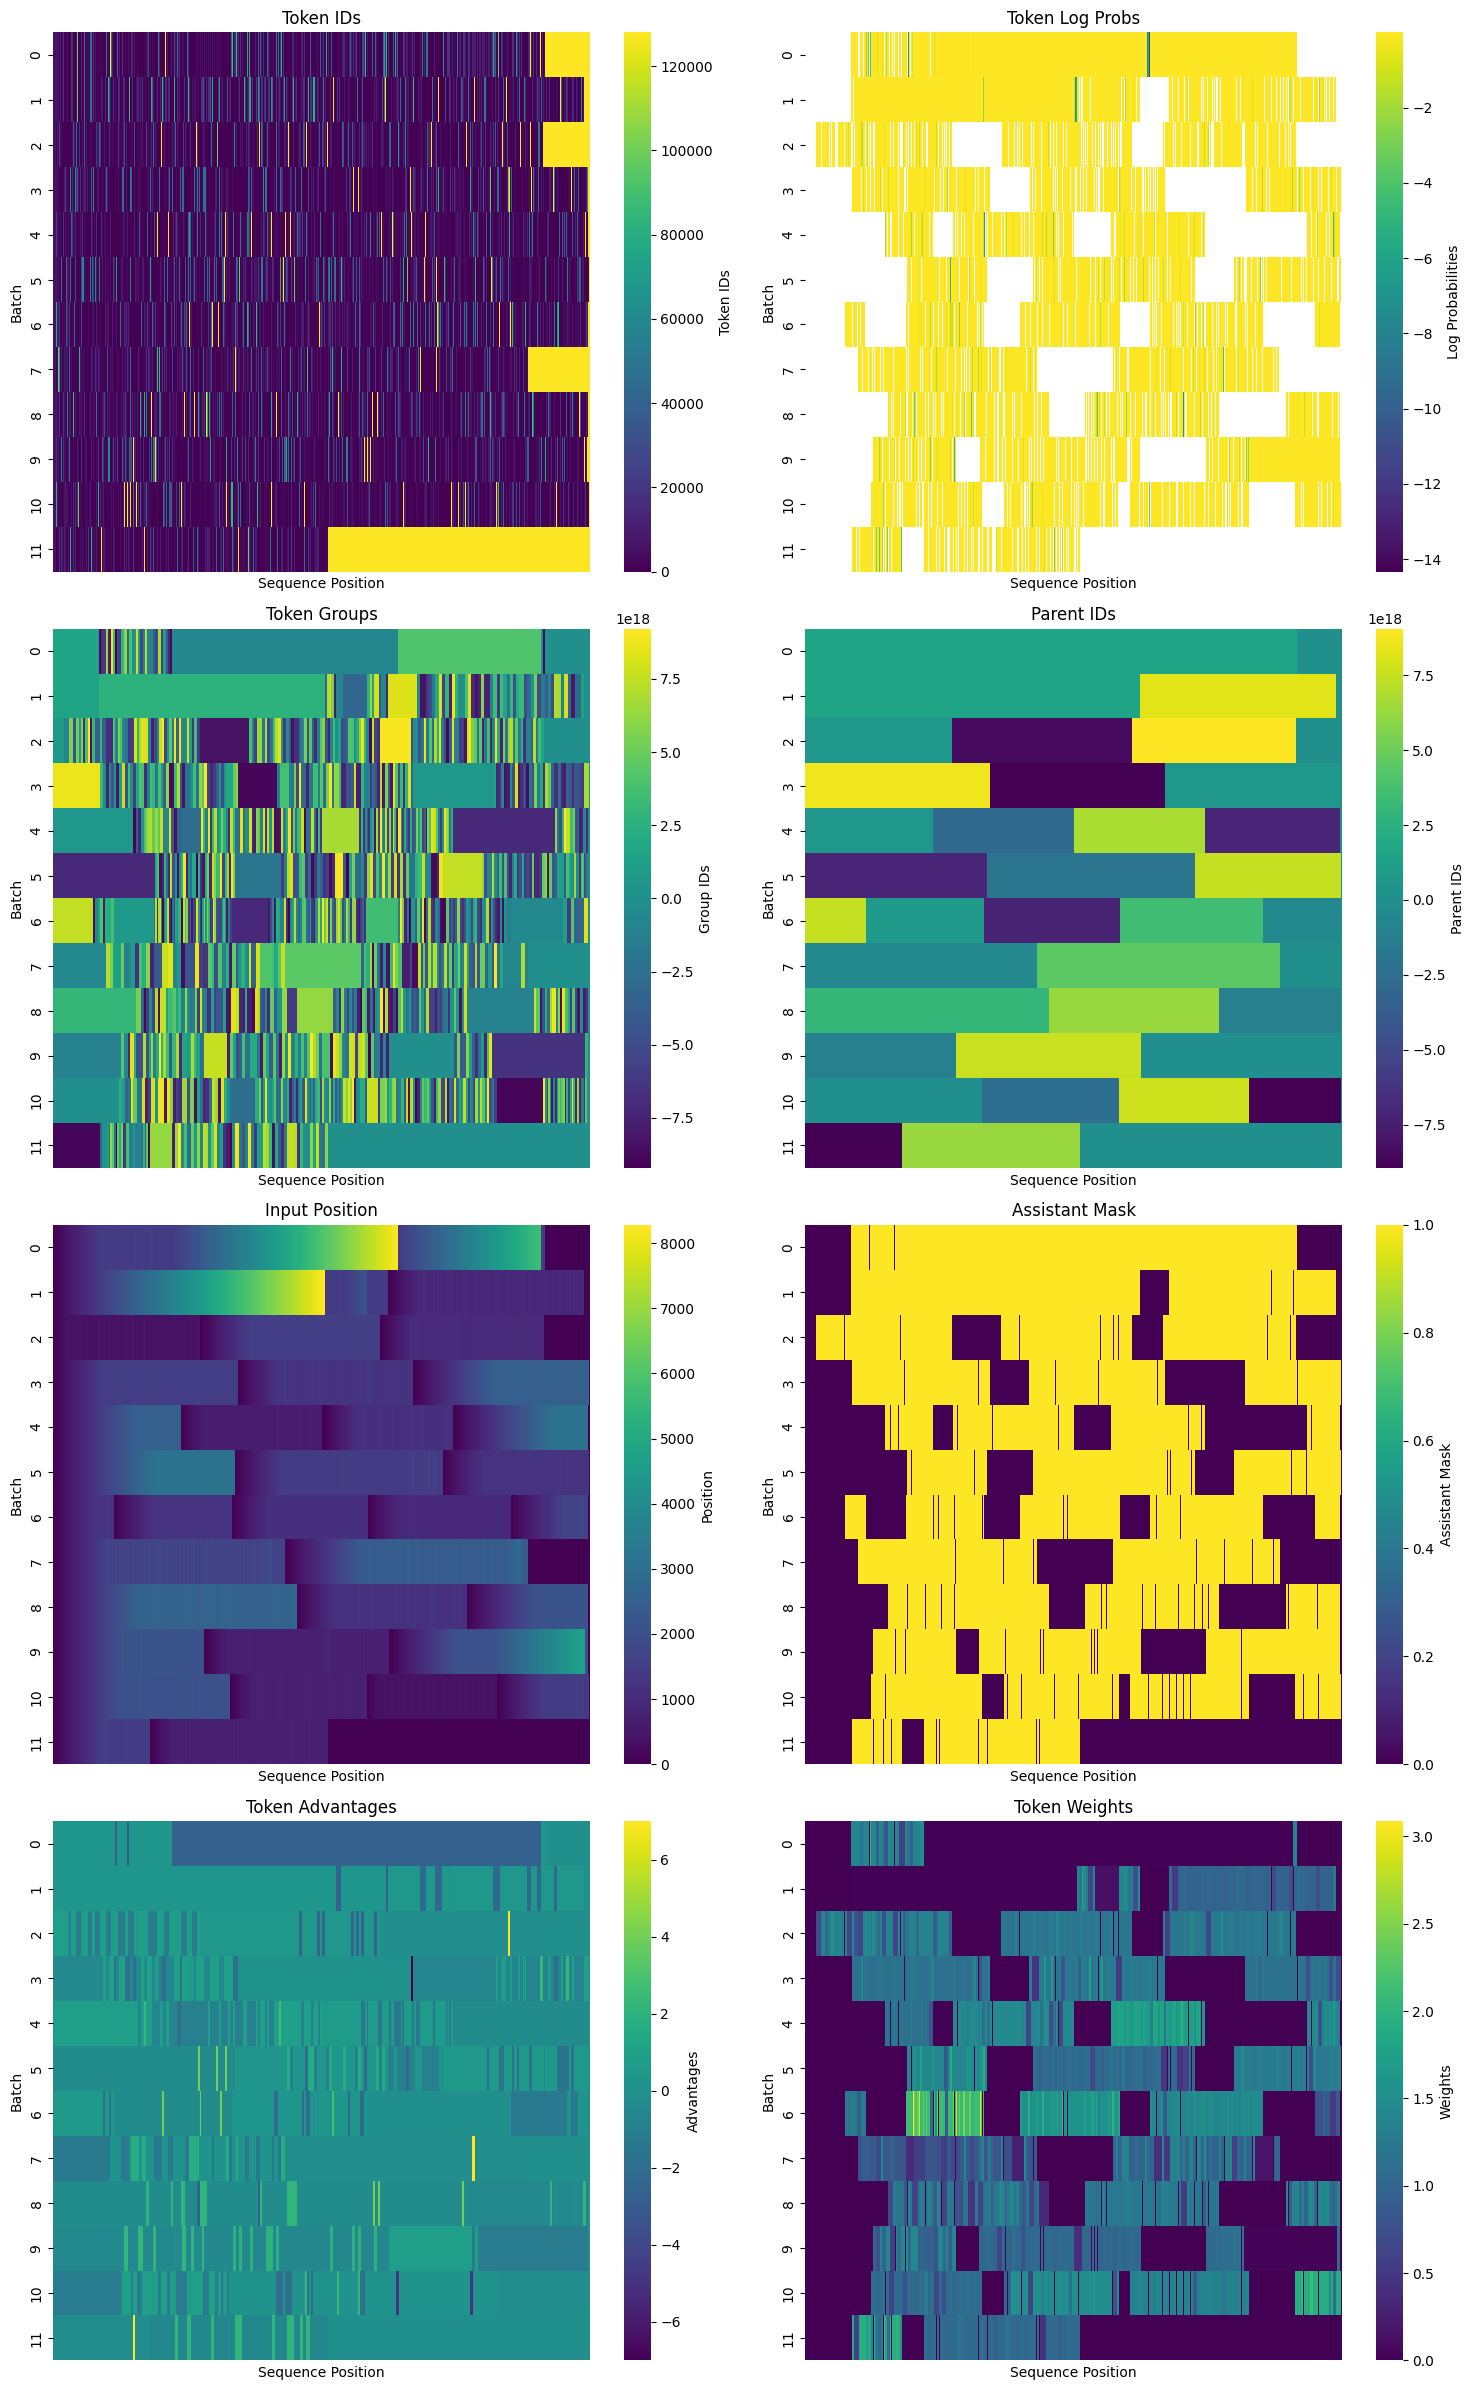

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0010
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 12
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741743548.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 17.01 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|6|Loss: 0.0007: 100%|██████████| 6/6 [01:42<00:00, 16.06s/it, loss=0.000726, policy=0.000726, entropy=0.0701, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
IN

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/072/0011 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/072/0011 --port=8000 --api-key=default
INFO 03-12 01:41:42 __init__.py:190] Automatically detected platform cuda.
INFO 03-12 01:41:43 api_server.py:840] vLLM API server version 0.7.2
INFO 03-12 01:41:43 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/072/0011', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.38it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.31it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.31it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.81it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.59it/s]



INFO 03-12 01:41:57 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-12 01:41:58 worker.py:267] Memory profiling takes 1.21 seconds
INFO 03-12 01:41:58 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 03-12 01:41:58 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 18.75GiB; the rest of the memory reserved for KV Cache is 41.28GiB.
INFO 03-12 01:41:58 executor_base.py:110] # CUDA blocks: 10568, # CPU blocks: 20480
INFO 03-12 01:41:58 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 20.64x
INFO 03-12 01:42:40 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.83 seconds
INFO 03-12 01:42:41 api_server.py:756] Using supplied chat template:
INFO 03-12 01:42:41 api_server.py:756] None
INFO 03-12 01:42:41 launcher.py:21] Available routes are:
INFO 03-12 01:42:41 launcher.py:29] Route: 

INFO:     Started server process [43275]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 03-12 01:42:41 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:32898 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

train: 100%|██████████| 1600/1600 [02:12<00:00,  4.02it/s, completion_tokens=113, prompt_tokens=1227, reward=0.28, acc=0.28, token_logprobs=299477]
Cleared iteration directory ./models/072/0010 except chat-completion-logs
Cleared iteration directory ./models/072/0009 except chat-completion-logs
Cleared iteration directory ./models/072/0008 except chat-completion-logs
Cleared iteration directory ./models/072/0007 except chat-completion-logs
Cleared iteration directory ./models/072/0006 except chat-completion-logs
Cleared iteration directory ./models/072/0004 except chat-completion-logs
Cleared iteration directory ./models/072/0003 except chat-completion-logs
Cleared iteration directory ./models/072/0002 except chat-completion-logs
Cleared iteration directory ./models/072/0001 except chat-completion-logs


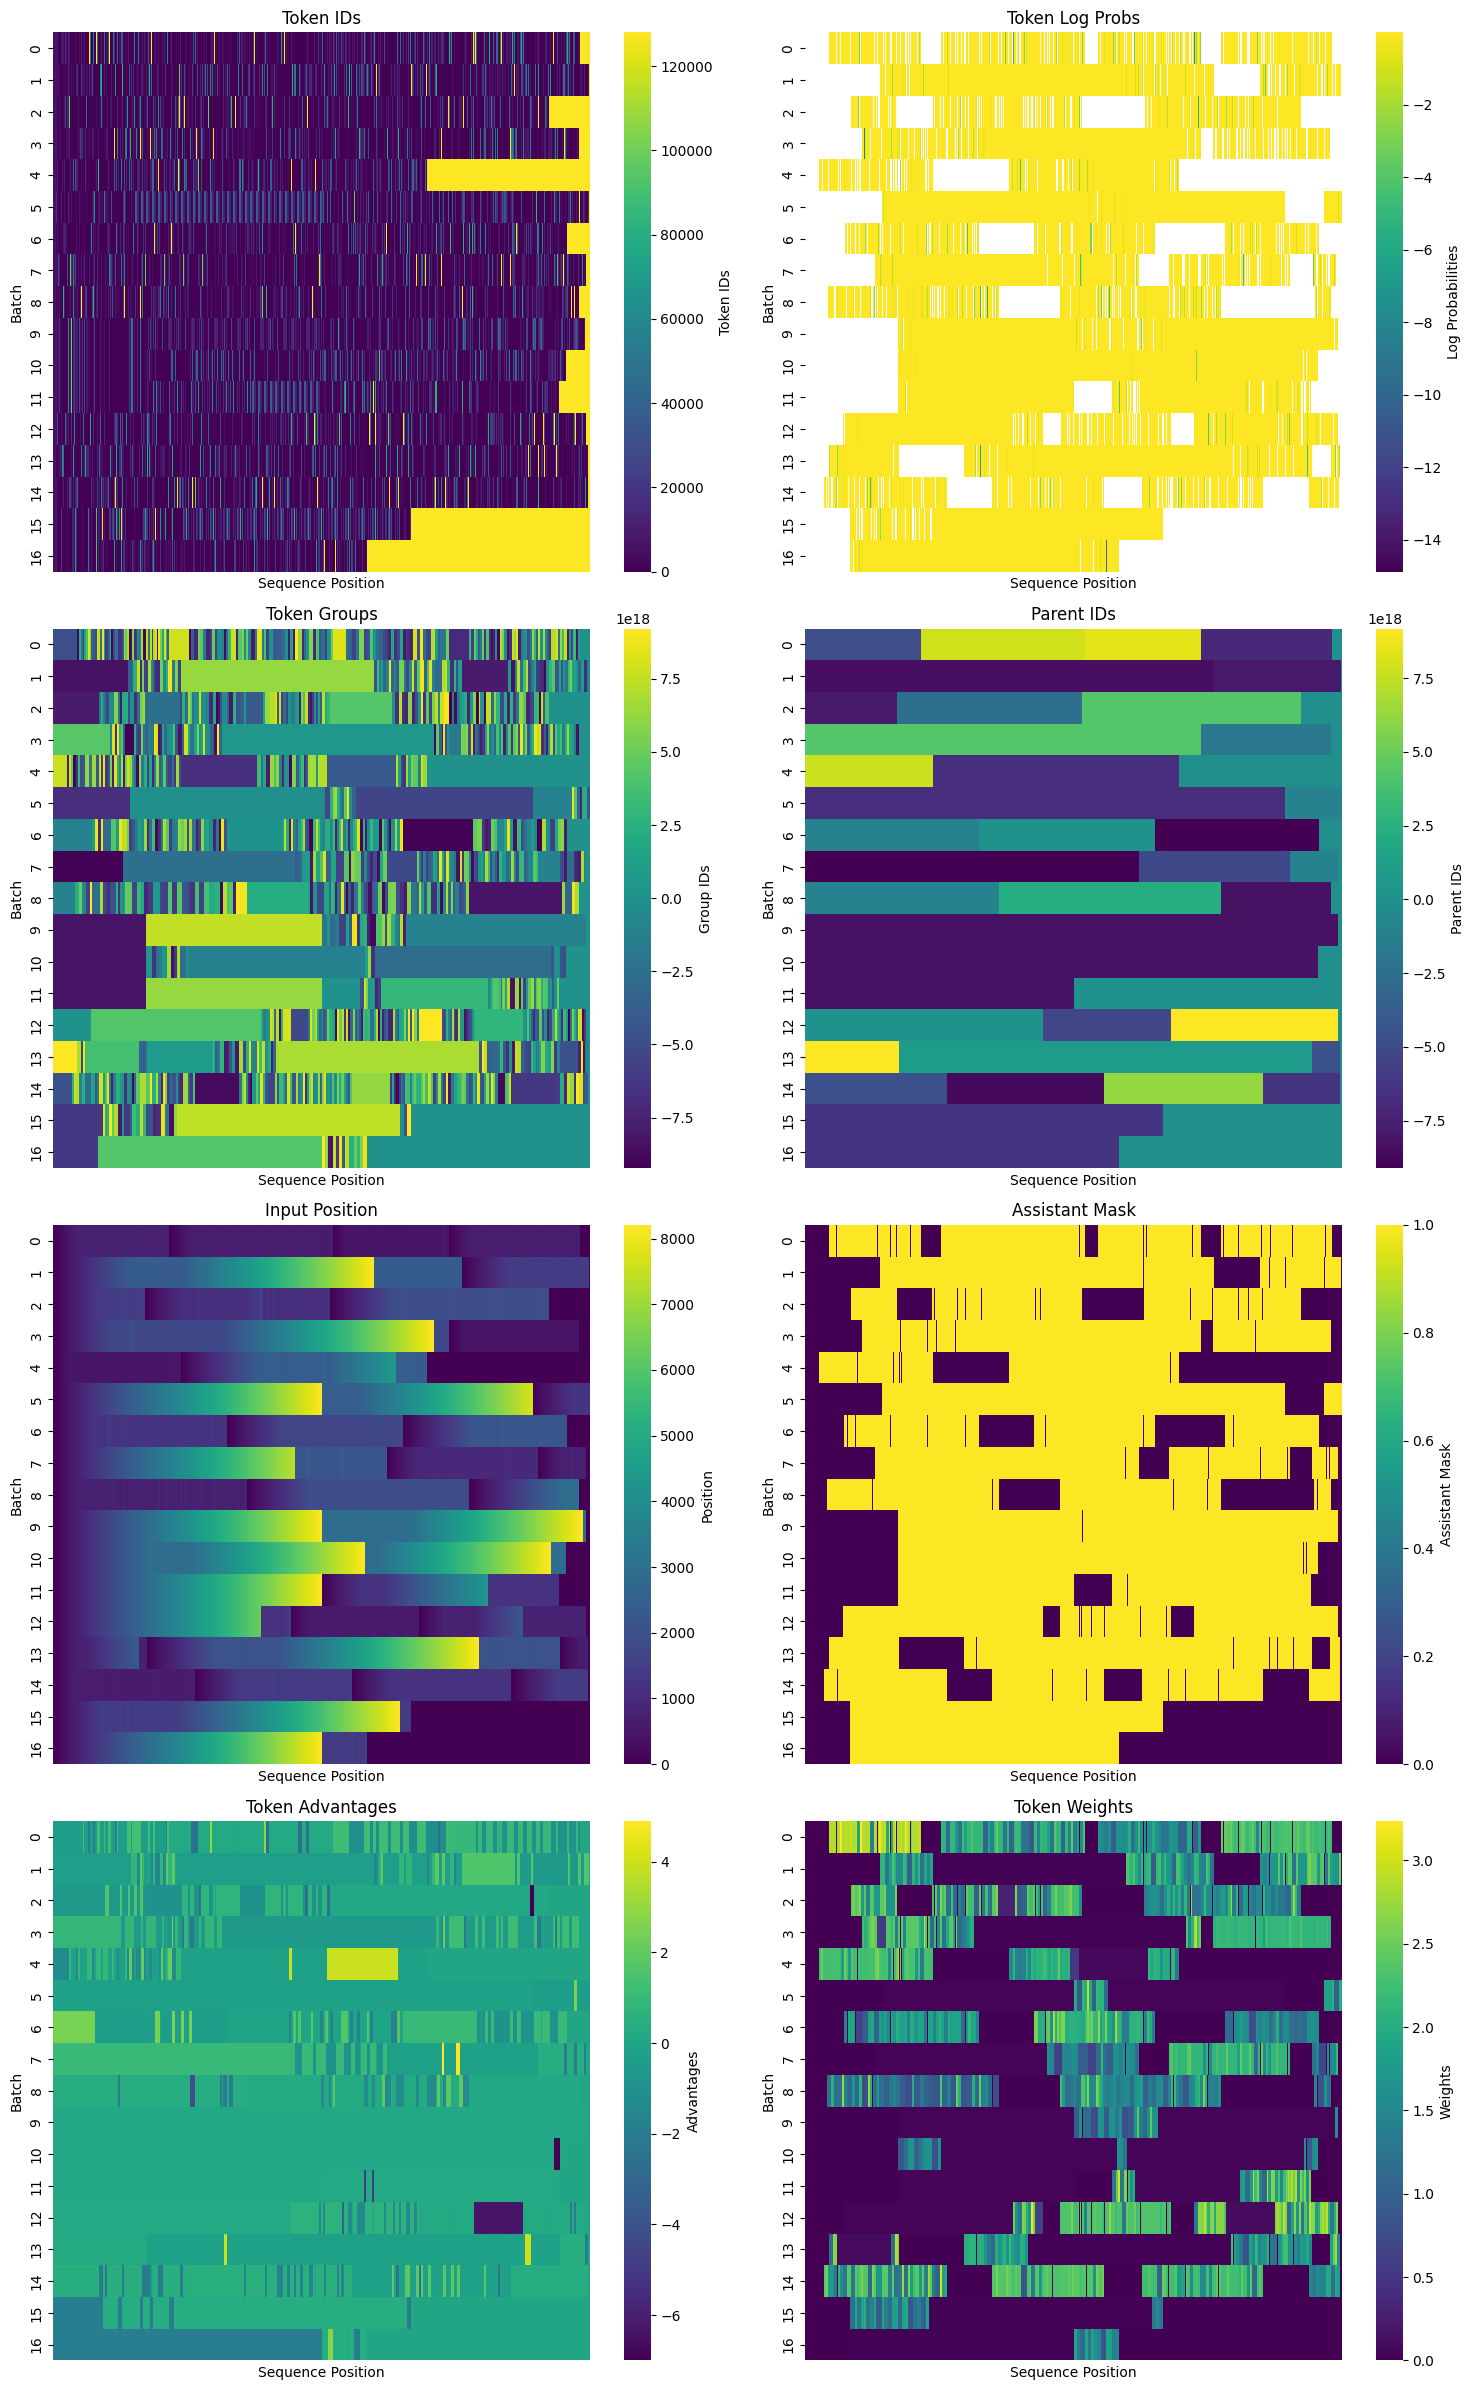

rsyncing /dev/shm/models/072 to gs:/atreides/openpipe/models/072
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/072/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/072/0011
  checkpoint_files:
  - ft-model-00001-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/072
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/072/tensors
  num_sequences: 17
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tan

Writing logs to models/072/logs/log_1741743914.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 16.86 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: -0.0169:  12%|█▎        | 1/8 [00:24<02:51, 24.50s/it, loss=-0.0169, policy=-0.0169, entropy=0.11, kl_div=nan]

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=4096,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=4096,
            max_num_batched_tokens=16384,
            num_scheduler_steps=16,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=360 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(2.6 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_dir=(
                f"{model_name}/chat-completion-logs"
                if model_name != model.base_model
                else f"{output_dir}/base-chat-completion-logs"
            ),
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
        # see ./logs/rsync.log for output
        asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
    except Exception:
        pass
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=model.tune_num_output_chunks,
            compile=True,
        ),
        verbosity=verbosity,
    )
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))